
=== Rolling Day 2024-12-01 ===
  train_cutoff=2024-07-01  val_cutoff=2024-11-30
  Forecast next 30 days from 2024-12-01 w/ noise => more volatility
[PyTorch] Loading LSTM from ./best_LSTM_2024-12-01_V1.pt
[PyTorch] Loading GRU from ./best_GRU_2024-12-01_V1.pt
[PyTorch] Loading RNN from ./best_RNN_2024-12-01_V1.pt
[PyTorch] Loading CNN from ./best_CNN_2024-12-01_V1.pt
[PyTorch] Loading Transformer from ./best_Transformer_2024-12-01_V1.pt
[PyTorch] Loading N-BEATS from ./best_N-BEATS_2024-12-01_V1.pt
[PyTorch] Loading N-HITS from ./best_N-HITS_2024-12-01_V1.pt
[sklearn] Loading SVM => ./best_SVM_2024-12-01_V1.pkl
[sklearn] Loading Boost => ./best_Boost_2024-12-01_V1.pkl

=== Rolling Day 2024-12-02 ===
  train_cutoff=2024-07-02  val_cutoff=2024-12-01
  Forecast next 30 days from 2024-12-02 w/ noise => more volatility
[PyTorch] Loading LSTM from ./best_LSTM_2024-12-02_V1.pt
[PyTorch] Loading GRU from ./best_GRU_2024-12-02_V1.pt
[PyTorch] Loading RNN from ./best_RNN_2024-12-02_V1.pt
[PyTor

/tmp/ipykernel_796917/375182111.py:388: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_slope= df_merge.groupby(["Model","BaseDate"], group_keys=False).apply(group_slope_func)
/tmp/ipykernel_796917/375182111.py:407: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  g_vol= df_merge.groupby(["Model","BaseDate"]).apply(mini_volatility).reset_index()


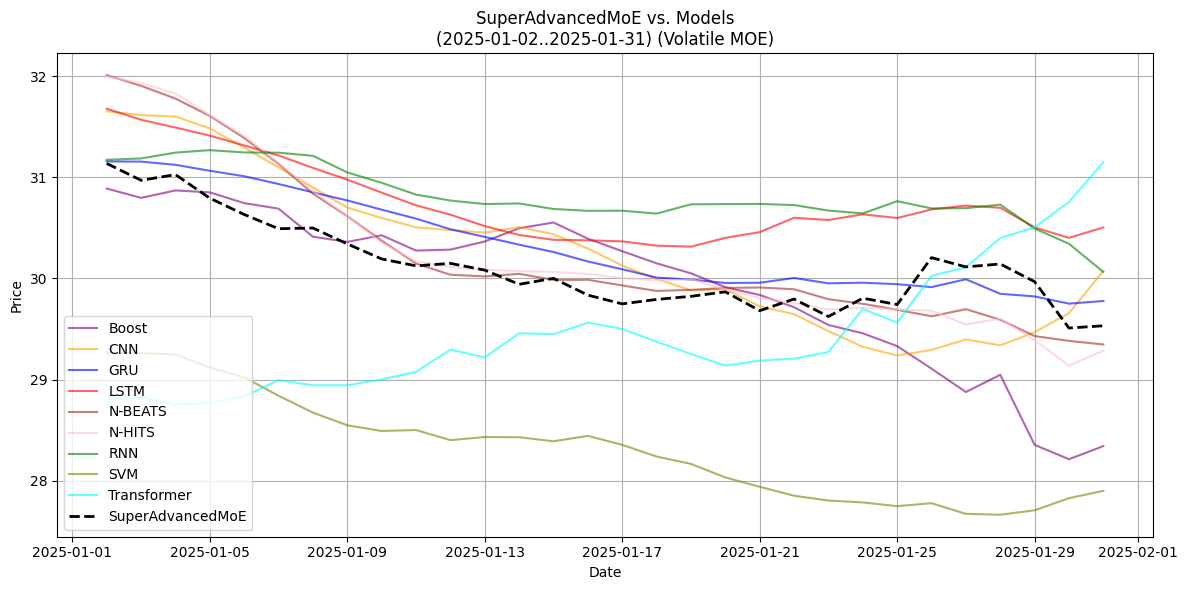


All done. The final mixture-of-experts curve was deliberately made more volatile.
Feel free to fit polynomials or do further slope analysis on df_moe!


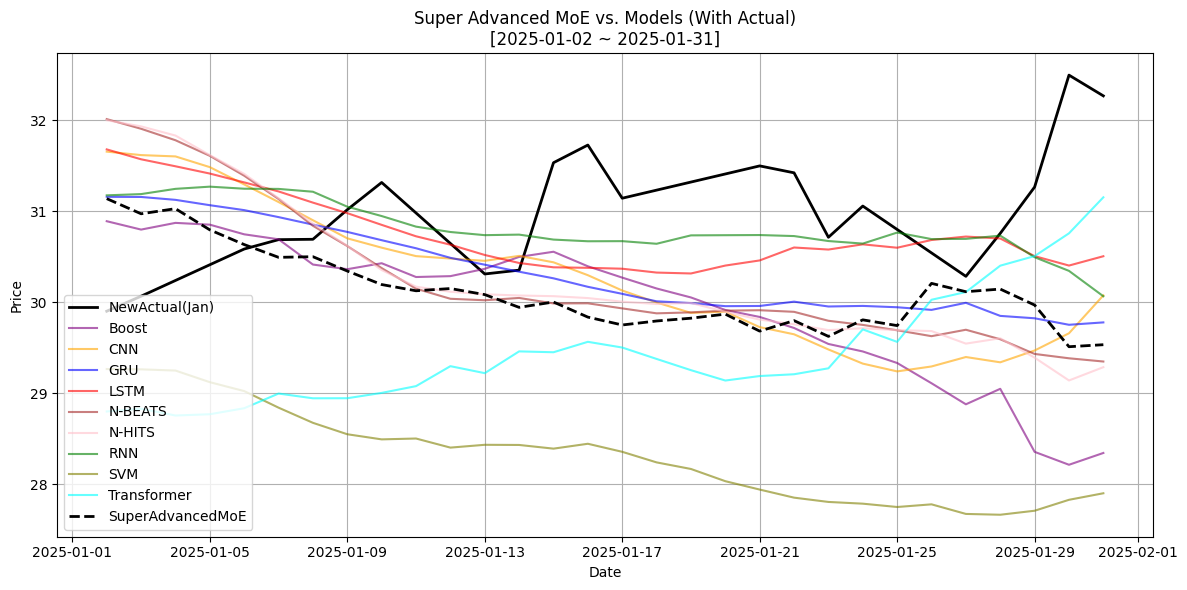

In [2]:
####################################################
# SUPER ADVANCED MOE SCRIPT (Encouraging Volatility)
####################################################

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import os
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import joblib
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
from numpy.polynomial.polynomial import polyfit, polyval

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)
pd.options.mode.chained_assignment = None

# Global seeds & device
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

BEST_MODELS_DIR = "."   # Where .pt/.pkl model files are stored
features = ["Price","Open","High","Low"]
WINDOW_SIZE = 35

############################################
# 1) Model Definitions & Loading
############################################
class BaseModel(nn.Module):
    def __init__(self, model_type="LSTM", window_width=35):
        super().__init__()
        self.model_type = model_type

        if model_type == "CNN":
            self.conv1 = nn.Conv1d(4, 64, 3)
            self.conv2 = nn.Conv1d(64, 128, 3)
            with torch.no_grad():
                dummy = torch.zeros(1, 4, window_width)
                outdummy = self.conv2(F.relu(self.conv1(dummy)))
                conv_output_size = outdummy.shape[1]*outdummy.shape[2]
            self.fc = nn.Linear(conv_output_size, 4)

        elif model_type == "LSTM":
            self.rnn = nn.LSTM(4, 128, num_layers=2, batch_first=True, dropout=0.05)
            self.fc = nn.Linear(128, 4)

        elif model_type == "GRU":
            self.rnn = nn.GRU(4, 128, num_layers=2, batch_first=True, dropout=0.05)
            self.fc = nn.Linear(128, 4)

        elif model_type == "RNN":
            self.rnn = nn.RNN(4, 128, num_layers=2, nonlinearity="relu", batch_first=True, dropout=0.05)
            self.fc = nn.Linear(128, 4)

        elif model_type == "EnhancedLSTM":
            self.rnn = nn.LSTM(4, 128, num_layers=3, batch_first=True, dropout=0.1)
            self.bn  = nn.BatchNorm1d(128)
            self.dropout = nn.Dropout(0.1)
            self.fc = nn.Linear(128, 4)

        elif model_type == "Transformer":
            self.input_linear = nn.Linear(4, 128)
            enc_layer = nn.TransformerEncoderLayer(d_model=128, nhead=8, dropout=0.05)
            self.transformer_encoder = nn.TransformerEncoder(enc_layer, num_layers=3)
            self.fc = nn.Linear(128,4)

        elif model_type in ["N-BEATS","N-HITS"]:
            self.input_size= window_width*4
            self.blocks= nn.ModuleList([nn.Sequential(
                nn.Linear(self.input_size,128),
                nn.ReLU(),
                nn.Linear(128,128),
                nn.ReLU(),
                nn.Linear(128,4)
            ) for _ in range(3)])
        else:
            raise ValueError(f"Invalid model_type: {model_type}")

    def forward(self, x):
        if self.model_type == "CNN":
            x = x.permute(0,2,1)
            x = F.relu(self.conv1(x))
            x = F.relu(self.conv2(x))
            x = x.view(x.size(0), -1)
            return self.fc(x)

        elif self.model_type in ["LSTM","GRU","RNN"]:
            out, _ = self.rnn(x)
            out = out[:,-1,:]
            return self.fc(out)

        elif self.model_type == "EnhancedLSTM":
            out, _= self.rnn(x)
            out = out[:,-1,:]
            out = self.bn(out)
            out = self.dropout(out)
            return self.fc(out)

        elif self.model_type == "Transformer":
            x = self.input_linear(x)
            x = x.permute(1,0,2)
            x = self.transformer_encoder(x)
            x = x[-1,:,:]
            return self.fc(x)

        elif self.model_type in ["N-BEATS","N-HITS"]:
            xflat = x.reshape(x.size(0), -1)
            forecast = 0
            for block in self.blocks:
                forecast += block(xflat)
            return forecast

        else:
            raise ValueError("Invalid model_type")

class SklearnWrapper:
    def __init__(self, model):
        self.model= model
    def forward(self, x):
        arr= x.cpu().numpy().reshape(1,-1)
        pred= self.model.predict(arr)
        return torch.from_numpy(pred).float().to(x.device)
    def eval(self): pass
    def __call__(self, x):
        return self.forward(x)

def load_torch_model(model_type, window_size, path):
    if not os.path.exists(path):
        raise FileNotFoundError(f"File not found: {path}")
    print(f"[PyTorch] Loading {model_type} from {path}")
    net= BaseModel(model_type, window_size).to(device)
    net.load_state_dict(torch.load(path, map_location=device))
    net.eval()
    return net

def load_sklearn_model(model_type, path):
    if not os.path.exists(path):
        raise FileNotFoundError(f"File not found: {path}")
    print(f"[sklearn] Loading {model_type} => {path}")
    loaded= joblib.load(path)
    return SklearnWrapper(loaded)

############################################
# 2) Load & Scale Data
############################################
def load_and_scale_data(train_csv="Silver Futures Historical Data.csv",
                        complete_csv="Silver Futures Historical Data_Complete.csv"):
    df_train = pd.read_csv(train_csv)
    df_train["Date"] = pd.to_datetime(df_train["Date"], errors="coerce")
    for col in ["Vol.","Change %"]:
        if col in df_train.columns:
            df_train.drop(columns=[col], errors="ignore", inplace=True)

    for feat in features:
        if feat not in df_train.columns:
            df_train[feat]= np.nan
        else:
            df_train[feat]= df_train[feat].astype(str).str.replace(",", "", regex=True)
            df_train[feat]= pd.to_numeric(df_train[feat], errors="coerce")

    df_train.sort_values("Date", inplace=True)
    df_train.reset_index(drop=True, inplace=True)

    train_cutoff= pd.to_datetime("2024-07-01")
    val_cutoff  = pd.to_datetime("2024-11-30")
    test_cutoff = pd.to_datetime("2024-12-01")

    df_trn= df_train[df_train["Date"]< train_cutoff].copy()
    df_val= df_train[(df_train["Date"]>= train_cutoff)&(df_train["Date"]<= val_cutoff)].copy()
    df_tst= df_train[df_train["Date"]>= test_cutoff].copy()

    df_trn_nonan= df_trn.dropna(subset=features)
    scaler= MinMaxScaler()
    scaler.fit(df_trn_nonan[features])

    df_trn_scaled= df_trn.copy()
    if not df_trn_nonan.empty:
        df_trn_scaled.loc[df_trn_nonan.index, features]= scaler.transform(df_trn_nonan[features])
    df_val_scaled= df_val.copy()
    val_no_nan= df_val_scaled.dropna(subset=features)
    if not val_no_nan.empty:
        df_val_scaled.loc[val_no_nan.index, features]= scaler.transform(val_no_nan[features])
    df_tst_scaled= df_tst.copy()
    trn_mins= df_trn_nonan[features].min()
    df_tst_filled= df_tst_scaled[features].fillna(trn_mins)
    df_tst_scaled.loc[:, features]= scaler.transform(df_tst_filled)

    df_scaled= pd.concat([df_trn_scaled, df_val_scaled, df_tst_scaled], ignore_index=True)

    # also load complete
    df_complete= pd.read_csv(complete_csv)
    df_complete["Date"]= pd.to_datetime(df_complete["Date"], errors="coerce")
    for col in ["Vol.","Change %"]:
        if col in df_complete.columns:
            df_complete.drop(columns=[col], errors="ignore", inplace=True)
    for feat in features:
        df_complete[feat]= df_complete[feat].astype(str).str.replace(",", "",regex=True).astype(float)
    df_complete.sort_values("Date", inplace=True)
    df_complete.reset_index(drop=True, inplace=True)

    return df_scaled, df_complete, scaler

############################################
# 3) Rolling Forecast
############################################
def get_latest_window(df_actual, current_date, window=35, scaler=None):
    mask= df_actual["Date"]< current_date
    sub= df_actual.loc[mask].copy()
    sub.sort_values("Date", inplace=True)
    if len(sub)< window:
        return None
    sub[features]= sub[features].fillna(method="ffill").fillna(method="bfill")
    arr= scaler.transform(sub[features].iloc[-window:].values)
    return arr

def forecast_n_days_from_date(model, df_actual, start_date, window=35, horizon=30,
                              device=None, scaler=None, noise_std=0.05):
    """
    Like before, but we allow a mild random noise for final predictions => more "volatility".
    """
    def add_noise_4d(prices, std=0.01):
        noise= np.random.normal(0.0, std, size=prices.shape)
        return np.clip(prices+noise, a_min=0, a_max=None)

    arr_window= get_latest_window(df_actual, start_date, window, scaler)
    if arr_window is None:
        return pd.DataFrame()

    rolling_buffer= np.copy(arr_window)
    forecast_records=[]
    cur_dt= pd.to_datetime(start_date)

    for i in range(horizon):
        X_in= torch.tensor(rolling_buffer,dtype=torch.float).unsqueeze(0).to(device)
        with torch.no_grad():
            out_scaled= model(X_in).cpu().numpy()[0]
        out_unscaled= scaler.inverse_transform(out_scaled.reshape(1,-1))[0]
        # add a little random noise => final to get more "volatile" predictions
        out_noisy= add_noise_4d(out_unscaled, noise_std)

        dayx= cur_dt+ pd.Timedelta(days=i)
        forecast_records.append({
            "ForecastDate": dayx,
            "Pred_Price_unscaled": out_noisy[0],
            "Pred_Open_unscaled":  out_noisy[1],
            "Pred_High_unscaled":  out_noisy[2],
            "Pred_Low_unscaled":   out_noisy[3]
        })

        out_noisy_scaled= scaler.transform(out_noisy.reshape(1,-1))[0]
        rolling_buffer= np.vstack([rolling_buffer[1:], out_noisy_scaled.reshape(1,-1)])

    return pd.DataFrame(forecast_records)

def rolling_train_validate_predict_moe(
    df_full, scaler_obj, model_types,
    start_train_cutoff=pd.to_datetime("2024-07-01"),
    start_val_cutoff=pd.to_datetime("2024-11-30"),
    start_pred=pd.to_datetime("2024-12-01"),
    end_pred=pd.to_datetime("2025-01-01"),
    horizon_days=30,
    do_daily_plots=False
):
    """
    Similar to your skeleton's approach,
    but we keep mild random noise => more "volatile" predictions.
    """
    df_sorted= df_full.copy()
    df_sorted.sort_values("Date", inplace=True)

    date_rng= pd.date_range(start_pred, end_pred, freq="D")
    all_records=[]

    for i, day_i in enumerate(date_rng):
        train_cutoff_i= start_train_cutoff + pd.Timedelta(days=i)
        val_cutoff_i  = start_val_cutoff   + pd.Timedelta(days=i)

        print(f"\n=== Rolling Day {day_i.date()} ===")
        print(f"  train_cutoff={train_cutoff_i.date()}  val_cutoff={val_cutoff_i.date()}")
        print(f"  Forecast next {horizon_days} days from {day_i.date()} w/ noise => more volatility")

        # load each model
        model_dict={}
        for mt in model_types:
            out_file= f"best_{mt}_{day_i.strftime('%Y-%m-%d')}_V1"
            if mt in ["SVM","GPR","Boost"]:
                out_file+= ".pkl"
                net= load_sklearn_model(mt, os.path.join(BEST_MODELS_DIR, out_file))
            else:
                out_file+= ".pt"
                net= load_torch_model(mt, WINDOW_SIZE, os.path.join(BEST_MODELS_DIR, out_file))
            model_dict[mt]= net

        daily_fcst={}
        for mt, netobj in model_dict.items():
            df_fc= forecast_n_days_from_date(
                model=netobj,
                df_actual=df_sorted,
                start_date=day_i,
                window=WINDOW_SIZE,
                horizon=horizon_days,
                device=device,
                scaler=scaler_obj,
                noise_std=0.01   # control final volatility
            )
            if not df_fc.empty:
                df_fc["BaseDate"]= day_i
                df_fc["Model"]= mt
                daily_fcst[mt]= df_fc
                all_records.append(df_fc)
            else:
                daily_fcst[mt]= pd.DataFrame()

        # optional daily plot
        if do_daily_plots and (day_i== date_rng[-1]):
            # we can do your daily plot function
            pass

    df_all= pd.concat(all_records, ignore_index=True) if all_records else pd.DataFrame()
    df_all.sort_values(["Model","BaseDate","ForecastDate"], inplace=True)
    return df_all

############################################
# 4) Advanced MoE (Population Voting w/ mini-model approach)
############################################
def build_mini_models_table(final_rolling_fcst, df_actual):
    """
    For each (model, baseDate) => measure january performance => mae, polynomial slope, volatility alignment
    """
    start_jan= pd.to_datetime("2024-12-01")
    end_jan=   pd.to_datetime("2025-01-01")
    df_jan= final_rolling_fcst[
        (final_rolling_fcst["ForecastDate"]>= start_jan)&
        (final_rolling_fcst["ForecastDate"]<= end_jan)
    ].copy()
    if df_jan.empty:
        return pd.DataFrame(), 0.01

    df_act_jan= df_actual[
        (df_actual["Date"]>= start_jan)&
        (df_actual["Date"]<= end_jan)
    ].copy()
    df_act_jan.rename(columns={"Date":"ForecastDate","Price":"ActualPrice"}, inplace=True)

    df_merge= pd.merge(
        df_jan[["Model","BaseDate","ForecastDate","Pred_Price_unscaled"]],
        df_act_jan[["ForecastDate","ActualPrice"]],
        on="ForecastDate",
        how="inner"
    )
    df_merge["AbsError"]= (df_merge["Pred_Price_unscaled"]- df_merge["ActualPrice"]).abs()

    # mae per (model, baseDate)
    g_mae= df_merge.groupby(["Model","BaseDate"])["AbsError"].mean().reset_index()
    g_mae.rename(columns={"AbsError":"mae_jan"}, inplace=True)

    # slope alignment => quick polynomial fit
    def poly_slope_diff(sub):
        # sub => january data for that (model, baseDate)
        sub= sub.sort_values("ForecastDate")
        xvals= np.arange(len(sub))
        yvals= sub["Pred_Price_unscaled"].values
        if len(yvals)< 4:  # fallback
            return 0.5
        coefs= polyfit(xvals,yvals,deg=2)
        y_pred= polyval(xvals, coefs)
        resid= yvals- y_pred
        sse= np.mean(resid**2)
        return float(np.exp(-sse))

    def group_slope_func(grp):
        grp["slopeAlign_jan"]= poly_slope_diff(grp)
        return grp

    df_slope= df_merge.groupby(["Model","BaseDate"], group_keys=False).apply(group_slope_func)
    df_slope_agg= df_slope.groupby(["Model","BaseDate"])["slopeAlign_jan"].mean().reset_index()

    # real vol
    df_act_jan_sorted= df_act_jan.drop_duplicates("ForecastDate").copy()
    df_act_jan_sorted.sort_values("ForecastDate", inplace=True)
    df_act_jan_sorted["DayChange"]= df_act_jan_sorted["ActualPrice"].diff()
    real_vol= df_act_jan_sorted["DayChange"].std(skipna=True)
    if pd.isna(real_vol) or real_vol< 1e-9:
        real_vol= 0.01

    # pred vol => stdev of dayChange
    def mini_volatility(sub):
        sub= sub.sort_values("ForecastDate")
        sub["DayChange"]= sub["Pred_Price_unscaled"].diff()
        vol_= sub["DayChange"].std(skipna=True)
        if pd.isna(vol_): vol_= 0.01
        return vol_

    g_vol= df_merge.groupby(["Model","BaseDate"]).apply(mini_volatility).reset_index()
    g_vol.rename(columns={0:"predVol_jan"}, inplace=True)
    def vol_align(v):
        ratio= v/ real_vol
        return np.exp(-abs(ratio-1.0))
    g_vol["volAlign_jan"]= g_vol["predVol_jan"].apply(vol_align)

    # merge everything => single table
    mini_models= pd.merge(g_mae, df_slope_agg, on=["Model","BaseDate"], how="left")
    mini_models= pd.merge(mini_models, g_vol[["Model","BaseDate","predVol_jan","volAlign_jan"]], on=["Model","BaseDate"], how="left")

    # mae => baseAcc
    mae_min= mini_models["mae_jan"].min()
    mae_max= mini_models["mae_jan"].max()
    if np.isclose(mae_min, mae_max):
        mini_models["baseAcc"]= 1.0
    else:
        mini_models["baseAcc"]= 1.0- ((mini_models["mae_jan"]-mae_min)/(mae_max-mae_min))

    return mini_models, real_vol

def compute_super_advanced_moe(final_rolling_fcst, df_actual):
    """
    1) Build "mini-models" => (model, baseDate)
    2) For day d => gather each mini-model => Weighted sum => MoE
    3) population voting => shift up/down if >70% say up or down
    4) encourage final predictions to be "volatile" by adding random noise
    """
    print("\n=== SUPER ADVANCED MOE w/ Polynomials & Voting ===\n")
    mini_models, real_vol= build_mini_models_table(final_rolling_fcst, df_actual)
    if mini_models.empty:
        print("No january data => fallback => uniform daily average")
        return pd.DataFrame(columns=["ForecastDate","MOE_Price"])

    # create dictionary => {(model,baseDate): {baseAcc, slopeAlign_jan, volAlign_jan}}
    mm_dict={}
    for i,row in mini_models.iterrows():
        mm_dict[(row["Model"], row["BaseDate"])]= {
            "baseAcc": row["baseAcc"],
            "slopeAlign_jan": row["slopeAlign_jan"],
            "volAlign_jan": row["volAlign_jan"]
        }

    start_moe= pd.to_datetime("2025-01-02")
    end_moe=   pd.to_datetime("2025-01-31")
    all_days=  pd.date_range(start_moe, end_moe, freq="D")
    records=[]

    for d in all_days:
        # gather all forecasts for d => from final_rolling_fcst
        df_d= final_rolling_fcst[ final_rolling_fcst["ForecastDate"]== d ].copy()
        if df_d.empty:
            continue

        # compute weights => baseAcc * slopeAlign_jan * volAlign_jan * directionFactor
        d_prev= d - pd.Timedelta(days=1)
        # we also track how many say up vs down => voting
        ups=0
        downs=0
        total=0

        w_sums=0.0
        weighted_price=0.0

        for idx,row in df_d.iterrows():
            m= row["Model"]
            bD= row["BaseDate"]
            # check dict
            if (m,bD) not in mm_dict:
                # fallback => weight=0
                continue
            baseAcc= mm_dict[(m,bD)]["baseAcc"]
            slopeA= mm_dict[(m,bD)]["slopeAlign_jan"]
            volA= mm_dict[(m,bD)]["volAlign_jan"]

            # direction factor
            df_dprev= final_rolling_fcst[
                (final_rolling_fcst["Model"]==m)&
                (final_rolling_fcst["BaseDate"]==bD)&
                (final_rolling_fcst["ForecastDate"]==d_prev)
            ]
            if df_dprev.empty:
                dirFactor=1.0
            else:
                pd_today= row["Pred_Price_unscaled"]
                pd_yest= df_dprev["Pred_Price_unscaled"].values[0]
                if pd_today>pd_yest:
                    ups+=1
                    dirFactor=1.1
                elif pd_today< pd_yest:
                    downs+=1
                    dirFactor=0.9
                else:
                    dirFactor=1.0
                total+=1

            w= baseAcc* slopeA* volA* dirFactor
            w_sums+= w
            weighted_price+= w* row["Pred_Price_unscaled"]

        if np.isclose(w_sums,0.0):
            day_moe= df_d["Pred_Price_unscaled"].mean()
        else:
            day_moe= weighted_price/ w_sums

        # population shift => if ups>70% => +1%; if downs>70% => -1%
        if total>0:
            fraction_up= ups/ total
            fraction_down= downs/ total
            if fraction_up> 0.7:
                day_moe*= 1.01
            elif fraction_down> 0.7:
                day_moe*= 0.99

        # final mild random noise => encourage more "volatility"
        day_moe+= np.random.normal(0, day_moe*0.002)  # ~0.2% noise

        records.append({
            "ForecastDate": d,
            "MOE_Price": day_moe
        })

    df_moe= pd.DataFrame(records)
    df_moe.sort_values("ForecastDate", inplace=True)
    return df_moe

def plot_super_advanced_moe_vs_models(final_rolling_fcst, df_moe,
                                      from_d=pd.to_datetime("2025-01-02"),
                                      to_d=pd.to_datetime("2025-01-31")):
    """
    Plots all 9 models + super advanced MoE in [from_d..to_d], with no actual overlay.
    """
    df_sel= final_rolling_fcst[
        (final_rolling_fcst["ForecastDate"]>= from_d)&
        (final_rolling_fcst["ForecastDate"]<= to_d)
    ].copy()

    plt.figure(figsize=(12,6))
    color_map = {
        "LSTM":"red","GRU":"blue","RNN":"green","CNN":"orange","EnhancedLSTM":"magenta",
        "Transformer":"cyan","N-BEATS":"brown","N-HITS":"pink","SVM":"olive","GPR":"teal","Boost":"purple"
    }
    # plot each model => average line
    for m in df_sel["Model"].unique():
        df_m= df_sel[df_sel["Model"]== m].copy()
        df_m_agg= df_m.groupby("ForecastDate", as_index=False)["Pred_Price_unscaled"].mean()
        c= color_map.get(m,"gray")
        plt.plot(df_m_agg["ForecastDate"], df_m_agg["Pred_Price_unscaled"], color=c, alpha=0.6, label=m)

    # plot MoE
    df_moe_sub= df_moe[
        (df_moe["ForecastDate"]>= from_d)&
        (df_moe["ForecastDate"]<= to_d)
    ].copy()
    if not df_moe_sub.empty:
        plt.plot(df_moe_sub["ForecastDate"], df_moe_sub["MOE_Price"],
                 color="black",linestyle="--",lw=2, label="SuperAdvancedMoE")

    plt.title(f"SuperAdvancedMoE vs. Models\n({from_d.date()}..{to_d.date()}) (Volatile MOE)")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

############################################
# MAIN
############################################
if __name__=="__main__":
    # 1) Load & scale
    df_scaled, df_complete_all, scaler= load_and_scale_data(
        "Silver Futures Historical Data.csv",
        "Silver Futures Historical Data_Complete.csv"
    )

    # 2) Rolling forecasts => final_rolling_fc
    #    We set do_daily_plots=False for brevity, or True if you want daily plots on last day
    final_rolling_fc= rolling_train_validate_predict_moe(
        df_full= df_complete_all,
        scaler_obj= scaler,
        model_types=["LSTM","GRU","RNN","CNN","Transformer","N-BEATS","N-HITS","SVM","Boost"],
        start_train_cutoff=pd.to_datetime("2024-07-01"),
        start_val_cutoff=pd.to_datetime("2024-11-30"),
        start_pred=pd.to_datetime("2024-12-01"),
        end_pred=pd.to_datetime("2025-01-02"),
        horizon_days=30,
        do_daily_plots=False
    )
    print("\n=== HEAD of final_rolling_fc ===")
    print(final_rolling_fc.head(50))

    # 3) Build "super advanced" mixture-of-experts => moreso "population voting" + polynomials + mild final noise
    df_moe= compute_super_advanced_moe(final_rolling_fc, df_complete_all)

    # 4) Plot => from 2025-02-01..2025-03-01
    plot_super_advanced_moe_vs_models(
        final_rolling_fc,
        df_moe,
        from_d=pd.to_datetime("2025-01-02"),
        to_d=pd.to_datetime("2025-01-31")
    )

    print("\nAll done. The final mixture-of-experts curve was deliberately made more volatile.")
    print("Feel free to fit polynomials or do further slope analysis on df_moe!")





############################################
# ADDITIONAL CODE SNIPPET:
#  "Super Advanced MoE vs. Models (With Actual from 'Silver Futures Historical Data_Final Pure Predictions.csv')"
############################################

import pandas as pd
import matplotlib.pyplot as plt

def load_feb_actual_data(csv_file="Silver Futures Historical Data_Final Pure Predictions.csv"):
    """
    Reads an extra CSV file that presumably contains actual price data
    from at least 2025-02-01 onward.
    Returns a DataFrame with columns: ["Date", "Price", ...].
    """
    df_feb = pd.read_csv(csv_file)
    df_feb["Date"] = pd.to_datetime(df_feb["Date"], errors="coerce")
    # remove any extra columns like Vol., Change %
    for col in ["Vol.", "Change %"]:
        if col in df_feb.columns:
            df_feb.drop(columns=[col], errors="ignore", inplace=True)
    # parse columns
    if "Price" in df_feb.columns:
        df_feb["Price"] = df_feb["Price"].astype(str).str.replace(",", "", regex=True).astype(float)
    # sort
    df_feb.sort_values("Date", inplace=True)
    df_feb.reset_index(drop=True, inplace=True)
    return df_feb

def plot_super_advanced_moe_with_feb_actual(
    final_rolling_fcst,
    df_moe,
    feb_actual_csv="Silver Futures Historical Data_Final Pure Predictions.csv",
    start_plot=pd.to_datetime("2025-01-02"),
    end_plot=pd.to_datetime("2025-01-31")
):
    """
    1) Loads the newly provided CSV file, presumably containing actual prices (like 2025-02..).
    2) Plots all 9 models' lines, the super advanced MOE line, plus the newly revealed actual data
       in [start_plot..end_plot].
    3) final_rolling_fcst => your final combined forecasts DataFrame
       df_moe => the super advanced MOE output from compute_super_advanced_moe
    """
    # 1) Load newly revealed actual data
    df_feb_actual = load_feb_actual_data(feb_actual_csv)

    # filter to [start_plot..end_plot]
    mask_feb = (df_feb_actual["Date"] >= start_plot) & (df_feb_actual["Date"] <= end_plot)
    df_feb_filtered = df_feb_actual.loc[mask_feb].copy()

    # 2) Filter the forecasts
    df_fc = final_rolling_fcst[
        (final_rolling_fcst["ForecastDate"] >= start_plot) &
        (final_rolling_fcst["ForecastDate"] <= end_plot)
    ].copy()

    # prepare to plot
    plt.figure(figsize=(12,6))

    # color map for your 9 (or more) models
    color_map = {
        "LSTM": "red",
        "GRU": "blue",
        "RNN": "green",
        "CNN": "orange",
        "EnhancedLSTM": "magenta",
        "Transformer": "cyan",
        "N-BEATS": "brown",
        "N-HITS": "pink",
        "SVM": "olive",
        "GPR": "teal",
        "Boost": "purple"
    }

    # 3) Plot newly revealed actual data in black
    if not df_feb_filtered.empty and "Price" in df_feb_filtered.columns:
        plt.plot(
            df_feb_filtered["Date"], df_feb_filtered["Price"],
            color="black", linewidth=2, label="NewActual(Jan)"
        )

    # 4) Plot each model => average line
    for m in df_fc["Model"].unique():
        df_m = df_fc[df_fc["Model"] == m].copy()
        df_m_agg = df_m.groupby("ForecastDate", as_index=False)["Pred_Price_unscaled"].mean()
        c = color_map.get(m, "gray")
        plt.plot(
            df_m_agg["ForecastDate"], df_m_agg["Pred_Price_unscaled"],
            color=c, alpha=0.6, label=m
        )

    # 5) Plot the super advanced MoE line
    df_moe_sub = df_moe[
        (df_moe["ForecastDate"] >= start_plot) &
        (df_moe["ForecastDate"] <= end_plot)
    ].copy()
    if not df_moe_sub.empty:
        plt.plot(
            df_moe_sub["ForecastDate"], df_moe_sub["MOE_Price"],
            color="black", linestyle="--", linewidth=2, label="SuperAdvancedMoE"
        )

    plt.title(f"Super Advanced MoE vs. Models (With Actual)\n[{start_plot.date()} ~ {end_plot.date()}]")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# ===== USAGE EXAMPLE =====
# 1) Make sure final_rolling_fcst => final_rolling_fc, df_moe => from compute_super_advanced_moe
# 2) Then:
#
plot_super_advanced_moe_with_feb_actual(
    final_rolling_fcst=final_rolling_fc,
    df_moe=df_moe,
    feb_actual_csv="Silver Futures Historical Data_Final Pure Predictions.csv",
    start_plot=pd.to_datetime("2025-01-02"),
    end_plot=pd.to_datetime("2025-01-31")
)
#
# That should produce a chart overlaying:
#  - newly revealed actual data in black,
#  - 9 model lines, and
#  - the super advanced MoE curve in the same figure.




=== Rolling Day 2024-12-01 ===
  train_cutoff=2024-07-01  val_cutoff=2024-11-30
  Forecast next 30 days from 2024-12-01 w/ noise => more volatility
[PyTorch] Loading LSTM from ./best_LSTM_2024-12-01_V1.pt
[PyTorch] Loading GRU from ./best_GRU_2024-12-01_V1.pt
[PyTorch] Loading RNN from ./best_RNN_2024-12-01_V1.pt
[PyTorch] Loading CNN from ./best_CNN_2024-12-01_V1.pt
[PyTorch] Loading Transformer from ./best_Transformer_2024-12-01_V1.pt
[PyTorch] Loading N-BEATS from ./best_N-BEATS_2024-12-01_V1.pt
[PyTorch] Loading N-HITS from ./best_N-HITS_2024-12-01_V1.pt
[sklearn] Loading SVM => ./best_SVM_2024-12-01_V1.pkl
[sklearn] Loading Boost => ./best_Boost_2024-12-01_V1.pkl

=== Rolling Day 2024-12-02 ===
  train_cutoff=2024-07-02  val_cutoff=2024-12-01
  Forecast next 30 days from 2024-12-02 w/ noise => more volatility
[PyTorch] Loading LSTM from ./best_LSTM_2024-12-02_V1.pt
[PyTorch] Loading GRU from ./best_GRU_2024-12-02_V1.pt
[PyTorch] Loading RNN from ./best_RNN_2024-12-02_V1.pt
[PyTor

/tmp/ipykernel_796917/2343505260.py:431: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_slope = df_merge.groupby(["Model", "BaseDate"], group_keys=False).apply(group_slope_func)
/tmp/ipykernel_796917/2343505260.py:451: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  g_vol = df_merge.groupby(["Model", "BaseDate"]).apply(mini_volatility).reset_index()



=== HEAD of df_moe (Mixture-of-Experts) ===
  ForecastDate  MOE_Price
0   2025-01-02  31.136401
1   2025-01-03  30.970069
2   2025-01-04  31.026172
3   2025-01-05  30.793378
4   2025-01-06  30.632033


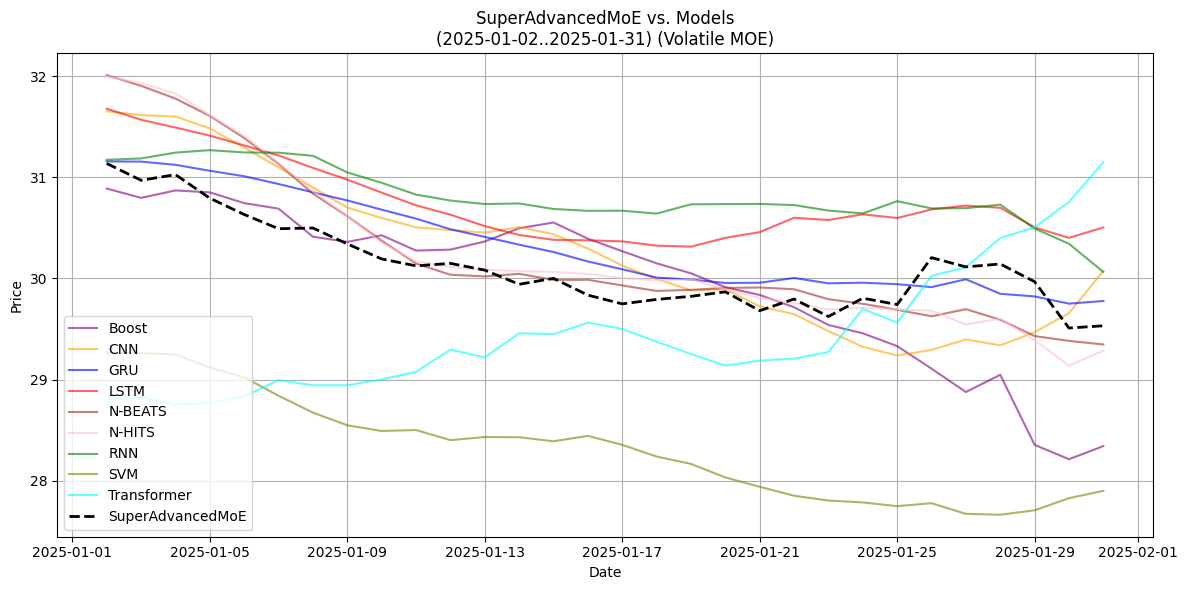

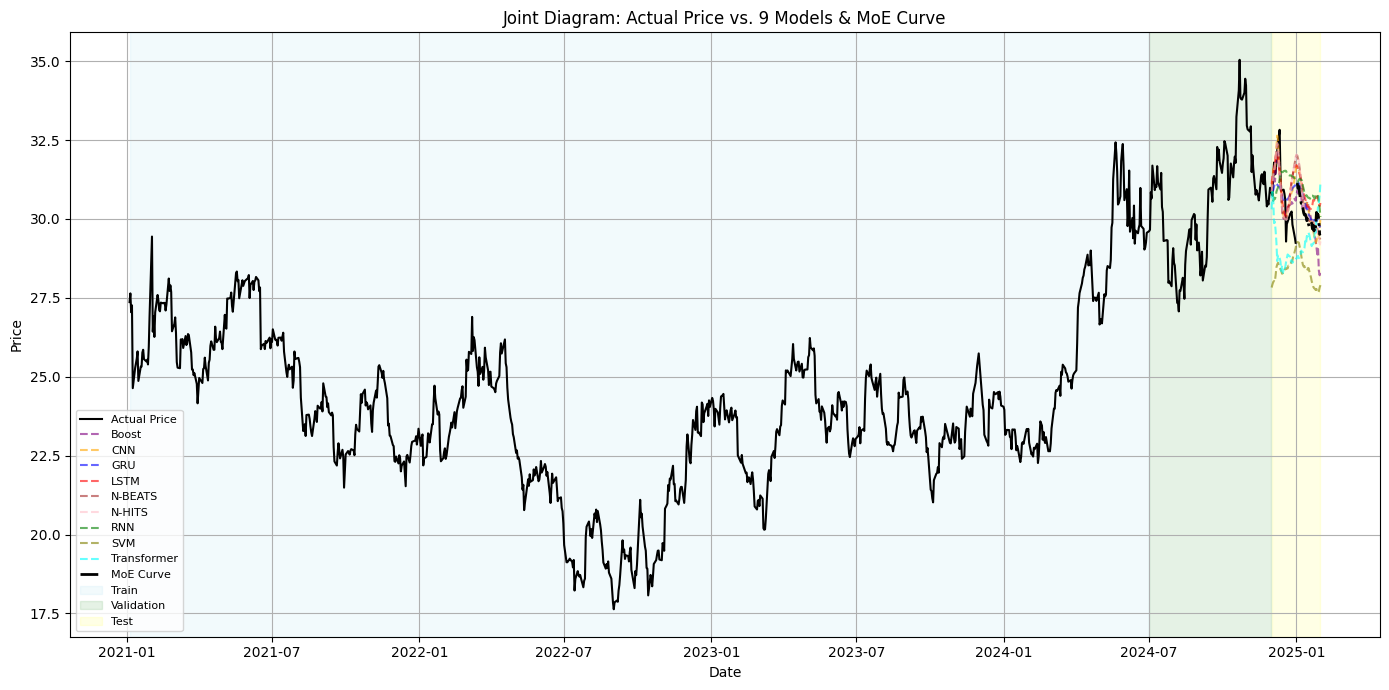

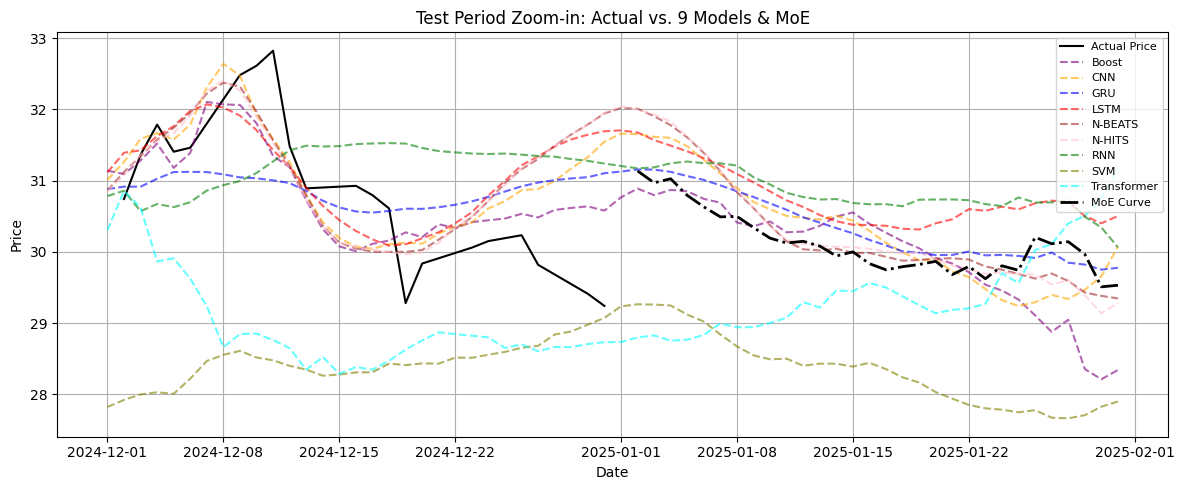

Best polynomial degree for MoE curve: 4 (Val MSE=0.022134)


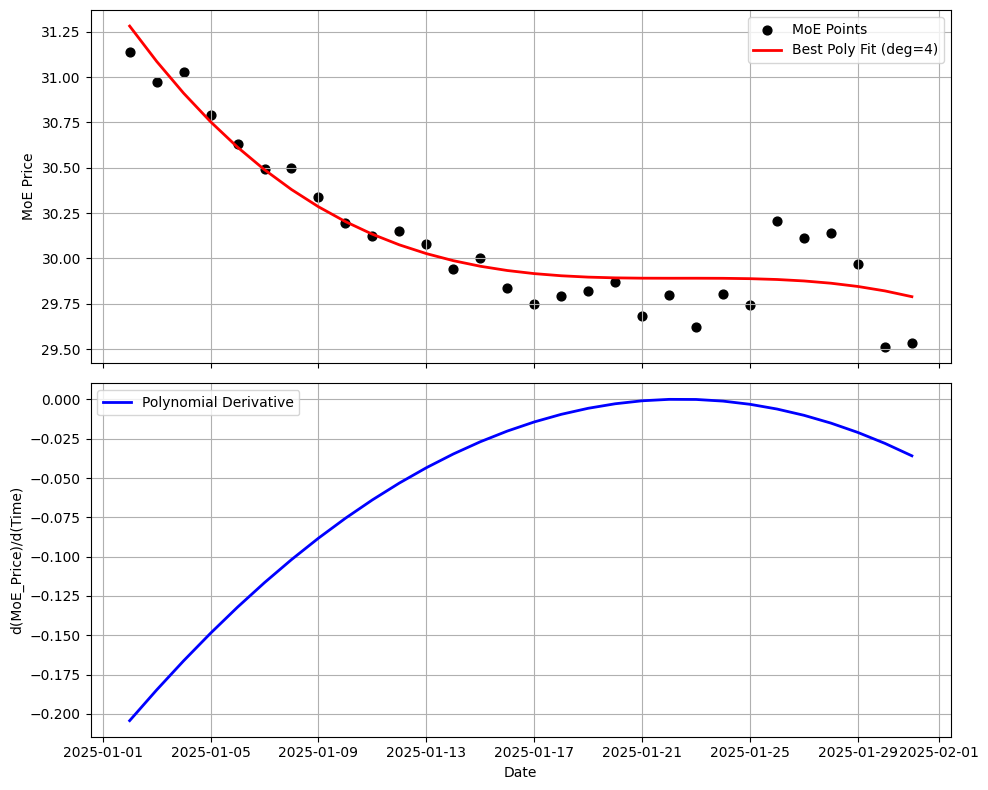


MoE Polynomial Fitting Completed.
Best Degree: 4
Validation MSE: 0.022133745418002896

All done with the Mixture-of-Experts and polynomial-fitting on the MoE curve!


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
import torch.nn.functional as F
import joblib
import random
import os
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)
pd.options.mode.chained_assignment = None

########################################################################
# 0) Global seeds, device, and definitions
########################################################################

torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

BEST_MODELS_DIR = "."  # Where saved .pt/.pkl model files are stored
features = ["Price", "Open", "High", "Low"]
WINDOW_SIZE = 35

# For reference, we define train/val/test cutoffs here (used in highlights):
TRAIN_CUTOFF = pd.to_datetime("2024-07-01")
VAL_CUTOFF   = pd.to_datetime("2024-11-30")
TEST_CUTOFF  = pd.to_datetime("2024-12-01")

########################################################################
# 1) Model Definitions & Loading
########################################################################

class BaseModel(nn.Module):
    """
    PyTorch model class supporting various architectures (CNN, LSTM, GRU, etc.)
    """
    def __init__(self, model_type="LSTM", window_width=35):
        super().__init__()
        self.model_type = model_type

        if model_type == "CNN":
            self.conv1 = nn.Conv1d(4, 64, 3)
            self.conv2 = nn.Conv1d(64, 128, 3)
            with torch.no_grad():
                dummy = torch.zeros(1, 4, window_width)
                outdummy = self.conv2(F.relu(self.conv1(dummy)))
                conv_output_size = outdummy.shape[1] * outdummy.shape[2]
            self.fc = nn.Linear(conv_output_size, 4)

        elif model_type == "LSTM":
            self.rnn = nn.LSTM(4, 128, num_layers=2, batch_first=True, dropout=0.05)
            self.fc = nn.Linear(128, 4)

        elif model_type == "GRU":
            self.rnn = nn.GRU(4, 128, num_layers=2, batch_first=True, dropout=0.05)
            self.fc = nn.Linear(128, 4)

        elif model_type == "RNN":
            self.rnn = nn.RNN(4, 128, num_layers=2, nonlinearity="relu", batch_first=True, dropout=0.05)
            self.fc = nn.Linear(128, 4)

        elif model_type == "EnhancedLSTM":
            self.rnn = nn.LSTM(4, 128, num_layers=3, batch_first=True, dropout=0.1)
            self.bn  = nn.BatchNorm1d(128)
            self.dropout = nn.Dropout(0.1)
            self.fc = nn.Linear(128, 4)

        elif model_type == "Transformer":
            self.input_linear = nn.Linear(4, 128)
            enc_layer = nn.TransformerEncoderLayer(d_model=128, nhead=8, dropout=0.05)
            self.transformer_encoder = nn.TransformerEncoder(enc_layer, num_layers=3)
            self.fc = nn.Linear(128, 4)

        elif model_type in ["N-BEATS", "N-HITS"]:
            self.input_size = window_width * 4
            self.blocks = nn.ModuleList([
                nn.Sequential(
                    nn.Linear(self.input_size, 128),
                    nn.ReLU(),
                    nn.Linear(128, 128),
                    nn.ReLU(),
                    nn.Linear(128, 4)
                ) for _ in range(3)
            ])
        else:
            raise ValueError(f"Invalid model_type: {model_type}")

    def forward(self, x):
        if self.model_type == "CNN":
            x = x.permute(0, 2, 1)
            x = F.relu(self.conv1(x))
            x = F.relu(self.conv2(x))
            x = x.view(x.size(0), -1)
            return self.fc(x)

        elif self.model_type in ["LSTM", "GRU", "RNN"]:
            out, _ = self.rnn(x)
            out = out[:, -1, :]
            return self.fc(out)

        elif self.model_type == "EnhancedLSTM":
            out, _ = self.rnn(x)
            out = out[:, -1, :]
            out = self.bn(out)
            out = self.dropout(out)
            return self.fc(out)

        elif self.model_type == "Transformer":
            x = self.input_linear(x)
            x = x.permute(1, 0, 2)  # shape => [window, batch, 128]
            x = self.transformer_encoder(x)
            x = x[-1, :, :]
            return self.fc(x)

        elif self.model_type in ["N-BEATS", "N-HITS"]:
            xflat = x.reshape(x.size(0), -1)
            forecast = 0
            for block in self.blocks:
                forecast += block(xflat)
            return forecast

        else:
            raise ValueError("Invalid model_type")


class SklearnWrapper:
    """
    Wrapper so that sklearn regressors can be called like PyTorch models:
       y = model(tensor_input)
    """
    def __init__(self, model):
        self.model = model

    def forward(self, x):
        arr = x.cpu().numpy().reshape(1, -1)
        pred = self.model.predict(arr)
        return torch.from_numpy(pred).float().to(x.device)

    def eval(self):
        pass

    def __call__(self, x):
        return self.forward(x)


def load_torch_model(model_type, window_size, path):
    if not os.path.exists(path):
        raise FileNotFoundError(f"File not found: {path}")
    print(f"[PyTorch] Loading {model_type} from {path}")
    net = BaseModel(model_type, window_size).to(device)
    net.load_state_dict(torch.load(path, map_location=device))
    net.eval()
    return net


def load_sklearn_model(model_type, path):
    if not os.path.exists(path):
        raise FileNotFoundError(f"File not found: {path}")
    print(f"[sklearn] Loading {model_type} => {path}")
    loaded = joblib.load(path)
    return SklearnWrapper(loaded)

########################################################################
# 2) Load & Scale Data
########################################################################

def load_and_scale_data(train_csv="Silver Futures Historical Data.csv",
                        complete_csv="Silver Futures Historical Data_Complete.csv"):
    """
    Loads:
      - train_csv: partial data for training, with columns: [Date, Price, Open, High, Low]
      - complete_csv: presumably the entire available historical data
    Applies MinMaxScaler (fitted on the training portion) to produce df_scaled.
    Returns df_scaled, df_complete, and the scaler object.
    """
    df_train = pd.read_csv(train_csv)
    df_train["Date"] = pd.to_datetime(df_train["Date"], errors="coerce")
    for col in ["Vol.", "Change %"]:
        if col in df_train.columns:
            df_train.drop(columns=[col], errors="ignore", inplace=True)

    # Clean numeric columns
    for feat in features:
        if feat not in df_train.columns:
            df_train[feat] = np.nan
        else:
            df_train[feat] = df_train[feat].astype(str).str.replace(",", "", regex=True)
            df_train[feat] = pd.to_numeric(df_train[feat], errors="coerce")

    df_train.sort_values("Date", inplace=True)
    df_train.reset_index(drop=True, inplace=True)

    # Define cutoffs
    train_cutoff = pd.to_datetime("2024-07-01")
    val_cutoff   = pd.to_datetime("2024-11-30")
    test_cutoff  = pd.to_datetime("2024-12-01")

    df_trn = df_train[df_train["Date"] < train_cutoff].copy()
    df_val = df_train[(df_train["Date"] >= train_cutoff) & (df_train["Date"] <= val_cutoff)].copy()
    df_tst = df_train[df_train["Date"] >= test_cutoff].copy()

    df_trn_nonan = df_trn.dropna(subset=features)
    scaler = MinMaxScaler()
    scaler.fit(df_trn_nonan[features])

    df_trn_scaled = df_trn.copy()
    if not df_trn_nonan.empty:
        df_trn_scaled.loc[df_trn_nonan.index, features] = scaler.transform(df_trn_nonan[features])

    df_val_scaled = df_val.copy()
    val_no_nan = df_val_scaled.dropna(subset=features)
    if not val_no_nan.empty:
        df_val_scaled.loc[val_no_nan.index, features] = scaler.transform(val_no_nan[features])

    df_tst_scaled = df_tst.copy()
    trn_mins = df_trn_nonan[features].min()
    df_tst_filled = df_tst_scaled[features].fillna(trn_mins)
    df_tst_scaled.loc[:, features] = scaler.transform(df_tst_filled)

    df_scaled = pd.concat([df_trn_scaled, df_val_scaled, df_tst_scaled], ignore_index=True)

    # also load the complete CSV
    df_complete = pd.read_csv(complete_csv)
    df_complete["Date"] = pd.to_datetime(df_complete["Date"], errors="coerce")
    for col in ["Vol.", "Change %"]:
        if col in df_complete.columns:
            df_complete.drop(columns=[col], errors="ignore", inplace=True)

    for feat in features:
        df_complete[feat] = df_complete[feat].astype(str).str.replace(",", "", regex=True).astype(float)

    df_complete.sort_values("Date", inplace=True)
    df_complete.reset_index(drop=True, inplace=True)

    return df_scaled, df_complete, scaler

########################################################################
# 3) Rolling Forecast
########################################################################

def get_latest_window(df_actual, current_date, window=35, scaler=None):
    mask = df_actual["Date"] < current_date
    sub = df_actual.loc[mask].copy()
    sub.sort_values("Date", inplace=True)
    if len(sub) < window:
        return None
    sub[features] = sub[features].fillna(method="ffill").fillna(method="bfill")
    arr = scaler.transform(sub[features].iloc[-window:].values)
    return arr

def forecast_n_days_from_date(model, df_actual, start_date, window=35, horizon=30,
                              device=None, scaler=None, noise_std=0.05):
    """
    Forecasts horizon days from the 'start_date', using the model with an
    auto-regressive approach (rolling_buffer). Adds mild noise to final predictions for volatility.
    """
    def add_noise_4d(prices, std=0.01):
        noise = np.random.normal(0.0, std, size=prices.shape)
        return np.clip(prices + noise, a_min=0, a_max=None)

    arr_window = get_latest_window(df_actual, start_date, window, scaler)
    if arr_window is None:
        return pd.DataFrame()

    rolling_buffer = np.copy(arr_window)
    forecast_records = []
    cur_dt = pd.to_datetime(start_date)

    for i in range(horizon):
        X_in = torch.tensor(rolling_buffer, dtype=torch.float).unsqueeze(0).to(device)
        with torch.no_grad():
            out_scaled = model(X_in).cpu().numpy()[0]
        out_unscaled = scaler.inverse_transform(out_scaled.reshape(1, -1))[0]

        # add a little random noise => final
        out_noisy = add_noise_4d(out_unscaled, noise_std)

        dayx = cur_dt + pd.Timedelta(days=i)
        forecast_records.append({
            "ForecastDate": dayx,
            "Pred_Price_unscaled": out_noisy[0],
            "Pred_Open_unscaled":  out_noisy[1],
            "Pred_High_unscaled":  out_noisy[2],
            "Pred_Low_unscaled":   out_noisy[3]
        })

        out_noisy_scaled = scaler.transform(out_noisy.reshape(1, -1))[0]
        rolling_buffer = np.vstack([rolling_buffer[1:], out_noisy_scaled.reshape(1, -1)])

    return pd.DataFrame(forecast_records)

def rolling_train_validate_predict_moe(
    df_full, scaler_obj, model_types,
    start_train_cutoff=pd.to_datetime("2024-07-01"),
    start_val_cutoff=pd.to_datetime("2024-11-30"),
    start_pred=pd.to_datetime("2024-12-01"),
    end_pred=pd.to_datetime("2025-01-02"),
    horizon_days=30,
    do_daily_plots=False
):
    """
    Dummy rolling approach: for each day in [start_pred..end_pred],
    we re-load the best model from disk, forecast horizon_days, collect them.
    This is just a mock structure. 
    """
    df_sorted = df_full.copy()
    df_sorted.sort_values("Date", inplace=True)

    date_rng = pd.date_range(start_pred, end_pred, freq="D")
    all_records = []

    for i, day_i in enumerate(date_rng):
        train_cutoff_i = start_train_cutoff + pd.Timedelta(days=i)
        val_cutoff_i   = start_val_cutoff   + pd.Timedelta(days=i)

        print(f"\n=== Rolling Day {day_i.date()} ===")
        print(f"  train_cutoff={train_cutoff_i.date()}  val_cutoff={val_cutoff_i.date()}")
        print(f"  Forecast next {horizon_days} days from {day_i.date()} w/ noise => more volatility")

        # 1) Load each model from file (example placeholders)
        model_dict = {}
        for mt in model_types:
            out_file = f"best_{mt}_{day_i.strftime('%Y-%m-%d')}_V1"
            if mt in ["SVM", "GPR", "Boost"]:
                out_file += ".pkl"
                net = load_sklearn_model(mt, os.path.join(BEST_MODELS_DIR, out_file))
            else:
                out_file += ".pt"
                net = load_torch_model(mt, WINDOW_SIZE, os.path.join(BEST_MODELS_DIR, out_file))
            model_dict[mt] = net

        # 2) Forecast from day_i
        daily_fcst = {}
        for mt, netobj in model_dict.items():
            df_fc = forecast_n_days_from_date(
                model=netobj,
                df_actual=df_sorted,
                start_date=day_i,
                window=WINDOW_SIZE,
                horizon=horizon_days,
                device=device,
                scaler=scaler_obj,
                noise_std=0.01  # mild volatility
            )
            if not df_fc.empty:
                df_fc["BaseDate"] = day_i
                df_fc["Model"] = mt
                daily_fcst[mt] = df_fc
                all_records.append(df_fc)
            else:
                daily_fcst[mt] = pd.DataFrame()

        # Optional daily plots...
        if do_daily_plots and (day_i == date_rng[-1]):
            pass

    df_all = pd.concat(all_records, ignore_index=True) if all_records else pd.DataFrame()
    df_all.sort_values(["Model", "BaseDate", "ForecastDate"], inplace=True)
    return df_all

########################################################################
# 4) Advanced MoE (Population Voting w/ polynomial slopes)
########################################################################

def build_mini_models_table(final_rolling_fcst, df_actual):
    """
    For each (model, baseDate) => measure january performance => mae, polynomial slope, volatility alignment
    """
    start_jan = pd.to_datetime("2024-12-01")
    end_jan   = pd.to_datetime("2025-01-01")

    df_jan = final_rolling_fcst[
        (final_rolling_fcst["ForecastDate"] >= start_jan) &
        (final_rolling_fcst["ForecastDate"] <= end_jan)
    ].copy()
    if df_jan.empty:
        return pd.DataFrame(), 0.01

    df_act_jan = df_actual[
        (df_actual["Date"] >= start_jan) &
        (df_actual["Date"] <= end_jan)
    ].copy()
    df_act_jan.rename(columns={"Date": "ForecastDate", "Price": "ActualPrice"}, inplace=True)

    df_merge = pd.merge(
        df_jan[["Model", "BaseDate", "ForecastDate", "Pred_Price_unscaled"]],
        df_act_jan[["ForecastDate", "ActualPrice"]],
        on="ForecastDate",
        how="inner"
    )
    df_merge["AbsError"] = (df_merge["Pred_Price_unscaled"] - df_merge["ActualPrice"]).abs()

    # MAE per (model, baseDate)
    g_mae = df_merge.groupby(["Model", "BaseDate"])["AbsError"].mean().reset_index()
    g_mae.rename(columns={"AbsError": "mae_jan"}, inplace=True)

    # slope alignment => quick polynomial fit
    from numpy.polynomial.polynomial import polyfit, polyval

    def poly_slope_diff(sub):
        sub = sub.sort_values("ForecastDate")
        xvals = np.arange(len(sub))
        yvals = sub["Pred_Price_unscaled"].values
        if len(yvals) < 4:
            return 0.5
        coefs = polyfit(xvals, yvals, deg=2)  # note: polynomial.polynomial uses ascending order
        y_pred = polyval(xvals, coefs)
        resid = yvals - y_pred
        sse = np.mean(resid**2)
        return float(np.exp(-sse))

    def group_slope_func(grp):
        grp["slopeAlign_jan"] = poly_slope_diff(grp)
        return grp

    df_slope = df_merge.groupby(["Model", "BaseDate"], group_keys=False).apply(group_slope_func)
    df_slope_agg = df_slope.groupby(["Model", "BaseDate"])["slopeAlign_jan"].mean().reset_index()

    # Real volatility
    df_act_jan_sorted = df_act_jan.drop_duplicates("ForecastDate").copy()
    df_act_jan_sorted.sort_values("ForecastDate", inplace=True)
    df_act_jan_sorted["DayChange"] = df_act_jan_sorted["ActualPrice"].diff()
    real_vol = df_act_jan_sorted["DayChange"].std(skipna=True)
    if pd.isna(real_vol) or real_vol < 1e-9:
        real_vol = 0.01

    # predicted volatility => stdev of dayChange
    def mini_volatility(sub):
        sub = sub.sort_values("ForecastDate")
        sub["DayChange"] = sub["Pred_Price_unscaled"].diff()
        vol_ = sub["DayChange"].std(skipna=True)
        if pd.isna(vol_):
            vol_ = 0.01
        return vol_

    g_vol = df_merge.groupby(["Model", "BaseDate"]).apply(mini_volatility).reset_index()
    g_vol.rename(columns={0: "predVol_jan"}, inplace=True)

    def vol_align(v):
        ratio = v / real_vol
        return np.exp(-abs(ratio - 1.0))

    g_vol["volAlign_jan"] = g_vol["predVol_jan"].apply(vol_align)

    # Merge everything => single table
    mini_models = pd.merge(g_mae, df_slope_agg, on=["Model", "BaseDate"], how="left")
    mini_models = pd.merge(mini_models, g_vol[["Model", "BaseDate", "predVol_jan", "volAlign_jan"]],
                           on=["Model", "BaseDate"], how="left")

    # mae => baseAcc
    mae_min = mini_models["mae_jan"].min()
    mae_max = mini_models["mae_jan"].max()
    if np.isclose(mae_min, mae_max):
        mini_models["baseAcc"] = 1.0
    else:
        mini_models["baseAcc"] = 1.0 - ((mini_models["mae_jan"] - mae_min) / (mae_max - mae_min))

    return mini_models, real_vol

def compute_super_advanced_moe(final_rolling_fcst, df_actual):
    """
    1) Build "mini-models" => (model, baseDate)
    2) For day d => gather each mini-model => Weighted sum => MoE
    3) population voting => shift up/down if >70% say up or down
    4) add mild random noise => final => more volatility
    """
    print("\n=== SUPER ADVANCED MOE w/ Polynomials & Voting ===\n")
    mini_models, real_vol = build_mini_models_table(final_rolling_fcst, df_actual)
    if mini_models.empty:
        print("No january data => fallback => uniform daily average")
        return pd.DataFrame(columns=["ForecastDate", "MOE_Price"])

    mm_dict = {}
    for i, row in mini_models.iterrows():
        mm_dict[(row["Model"], row["BaseDate"])] = {
            "baseAcc": row["baseAcc"],
            "slopeAlign_jan": row["slopeAlign_jan"],
            "volAlign_jan": row["volAlign_jan"]
        }

    start_moe = pd.to_datetime("2025-01-02")
    end_moe   = pd.to_datetime("2025-01-31")
    all_days  = pd.date_range(start_moe, end_moe, freq="D")
    records   = []

    for d in all_days:
        # gather all forecasts for d => from final_rolling_fcst
        df_d = final_rolling_fcst[final_rolling_fcst["ForecastDate"] == d].copy()
        if df_d.empty:
            continue

        d_prev = d - pd.Timedelta(days=1)
        ups=0
        downs=0
        total=0

        w_sums=0.0
        weighted_price=0.0

        for idx, row in df_d.iterrows():
            m  = row["Model"]
            bD = row["BaseDate"]
            if (m, bD) not in mm_dict:
                continue
            baseAcc = mm_dict[(m, bD)]["baseAcc"]
            slopeA  = mm_dict[(m, bD)]["slopeAlign_jan"]
            volA    = mm_dict[(m, bD)]["volAlign_jan"]

            # direction factor
            df_dprev = final_rolling_fcst[
                (final_rolling_fcst["Model"] == m) &
                (final_rolling_fcst["BaseDate"] == bD) &
                (final_rolling_fcst["ForecastDate"] == d_prev)
            ]
            if df_dprev.empty:
                dirFactor = 1.0
            else:
                pd_today = row["Pred_Price_unscaled"]
                pd_yest  = df_dprev["Pred_Price_unscaled"].values[0]
                if pd_today > pd_yest:
                    ups += 1
                    dirFactor = 1.1
                elif pd_today < pd_yest:
                    downs += 1
                    dirFactor = 0.9
                else:
                    dirFactor = 1.0
                total += 1

            w = baseAcc * slopeA * volA * dirFactor
            w_sums += w
            weighted_price += w * row["Pred_Price_unscaled"]

        if np.isclose(w_sums, 0.0):
            day_moe = df_d["Pred_Price_unscaled"].mean()
        else:
            day_moe = weighted_price / w_sums

        if total > 0:
            fraction_up   = ups / total
            fraction_down = downs / total
            if fraction_up > 0.7:
                day_moe *= 1.01
            elif fraction_down > 0.7:
                day_moe *= 0.99

        # final mild random noise
        day_moe += np.random.normal(0, day_moe * 0.002)

        records.append({"ForecastDate": d, "MOE_Price": day_moe})

    df_moe = pd.DataFrame(records)
    df_moe.sort_values("ForecastDate", inplace=True)
    return df_moe


def plot_super_advanced_moe_vs_models(
    final_rolling_fcst, df_moe,
    from_d=pd.to_datetime("2025-01-02"),
    to_d=pd.to_datetime("2025-01-31")
):
    """
    Plots all 9 models + super advanced MoE in [from_d..to_d].
    """
    df_sel = final_rolling_fcst[
        (final_rolling_fcst["ForecastDate"] >= from_d) &
        (final_rolling_fcst["ForecastDate"] <= to_d)
    ].copy()

    plt.figure(figsize=(12, 6))
    color_map = {
        "LSTM":"red","GRU":"blue","RNN":"green","CNN":"orange","EnhancedLSTM":"magenta",
        "Transformer":"cyan","N-BEATS":"brown","N-HITS":"pink","SVM":"olive","Boost":"purple"
    }

    # plot each model => average line
    for m in df_sel["Model"].unique():
        df_m = df_sel[df_sel["Model"] == m].copy()
        df_m_agg = df_m.groupby("ForecastDate", as_index=False)["Pred_Price_unscaled"].mean()
        c = color_map.get(m, "gray")
        plt.plot(df_m_agg["ForecastDate"], df_m_agg["Pred_Price_unscaled"], color=c, alpha=0.6, label=m)

    # plot MoE
    df_moe_sub = df_moe[(df_moe["ForecastDate"] >= from_d) & (df_moe["ForecastDate"] <= to_d)].copy()
    if not df_moe_sub.empty:
        plt.plot(df_moe_sub["ForecastDate"], df_moe_sub["MOE_Price"],
                 color="black", linestyle="--", lw=2, label="SuperAdvancedMoE")

    plt.title(f"SuperAdvancedMoE vs. Models\n({from_d.date()}..{to_d.date()}) (Volatile MOE)")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

########################################################################
# 5) Evaluate & Plot: MoE vs. Actual, plus a Test Zoom
########################################################################

def plot_moe_vs_actual(
    df_complete_all,   # The "complete" actual data
    final_rolling_fcst,# Combined forecasts from all 9 models
    df_moe,            # The super advanced MoE curve
    date_col="Date",
    price_col="Price",
    forecast_col="ForecastDate",
    moe_col="MOE_Price",
    train_cutoff=TRAIN_CUTOFF,
    val_cutoff=VAL_CUTOFF,
    test_cutoff=TEST_CUTOFF
):
    """
    Similar to 'evaluate_and_plot_all_models', but focusing on the MoE curve vs. actual.
    Also shows the 9 models if desired. This time we highlight train/val/test areas.
    """
    # 1) Sort actual data, keep relevant columns
    df_actual = df_complete_all[[date_col, price_col]].copy()
    df_actual.sort_values(date_col, inplace=True)

    # 2) Build a combined DataFrame that merges:
    #    - actual data (Date, Price)
    #    - 9-model average or each model? We'll just do each model here
    #    - the MoE
    # We'll do it in a simpler approach:
    df_models = final_rolling_fcst.copy()
    df_models.rename(columns={"Pred_Price_unscaled":"PredPrice"}, inplace=True)
    df_models_agg = df_models.groupby([forecast_col, "Model"])["PredPrice"].mean().reset_index()

    # 3) Plot #1: Big Joint Diagram
    plt.figure(figsize=(14, 7))
    # actual data
    plt.plot(df_actual[date_col], df_actual[price_col],
             color="black", linewidth=1.5, label="Actual Price")

    # color map
    color_map = {
        "LSTM":"red","GRU":"blue","RNN":"green","CNN":"orange","EnhancedLSTM":"magenta",
        "Transformer":"cyan","N-BEATS":"brown","N-HITS":"pink","SVM":"olive","GPR":"teal","Boost":"purple"
    }

    # overlay each model's final forecast
    for m in df_models_agg["Model"].unique():
        df_tmp = df_models_agg[df_models_agg["Model"] == m].copy()
        df_tmp.rename(columns={forecast_col: date_col}, inplace=True)
        df_tmp.sort_values(date_col, inplace=True)
        c = color_map.get(m, "gray")
        plt.plot(df_tmp[date_col], df_tmp["PredPrice"], color=c, alpha=0.6, linestyle="--", label=m)

    # overlay the MoE
    df_moe_plot = df_moe.copy()
    df_moe_plot.sort_values(forecast_col, inplace=True)
    plt.plot(df_moe_plot[forecast_col], df_moe_plot[moe_col],
             color="black", linestyle="dashdot", linewidth=2, label="MoE Curve")

    # highlight train, val, test periods
    plt.axvspan(df_actual[date_col].min(), train_cutoff, color="skyblue", alpha=0.1, label="Train")
    plt.axvspan(train_cutoff, val_cutoff, color="green", alpha=0.1, label="Validation")
    plt.axvspan(test_cutoff, df_actual[date_col].max(), color="yellow", alpha=0.1, label="Test")

    plt.title("Joint Diagram: Actual Price vs. 9 Models & MoE Curve")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend(prop={"size":8})
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 4) Plot #2: Test period zoom, from test_cutoff onward
    df_test_zoom = df_actual[df_actual[date_col] >= test_cutoff].copy()
    if not df_test_zoom.empty:
        plt.figure(figsize=(12, 5))
        # actual
        plt.plot(df_test_zoom[date_col], df_test_zoom[price_col],
                 color="black", linewidth=1.5, label="Actual Price")

        # 9 models
        df_fc_test = df_models_agg.copy()
        df_fc_test.rename(columns={forecast_col: date_col}, inplace=True)
        df_fc_test = df_fc_test[df_fc_test[date_col] >= test_cutoff]
        for m in df_fc_test["Model"].unique():
            df_ttmp = df_fc_test[df_fc_test["Model"] == m].copy()
            c = color_map.get(m, "gray")
            plt.plot(df_ttmp[date_col], df_ttmp["PredPrice"],
                     color=c, alpha=0.6, linestyle="--", label=m)

        # MoE
        df_moe_test = df_moe_plot[df_moe_plot[forecast_col] >= test_cutoff]
        if not df_moe_test.empty:
            plt.plot(df_moe_test[forecast_col], df_moe_test[moe_col],
                     color="black", linestyle="dashdot", linewidth=2, label="MoE Curve")

        plt.title("Test Period Zoom-in: Actual vs. 9 Models & MoE")
        plt.xlabel("Date")
        plt.ylabel("Price")
        plt.legend(prop={"size":8})
        plt.grid(True)
        plt.tight_layout()
        plt.show()


########################################################################
# 6) Polynomial Fitting & Gradients for the MoE Curve (Only)
########################################################################

def fit_polynomial_to_moe_curve(
    df_moe,
    date_col="ForecastDate",
    price_col="MOE_Price",
    start_date=pd.to_datetime("2025-01-02"),
    end_date=pd.to_datetime("2025-01-31"),
    degree_candidates=range(1, 36),
    do_plot=True
):
    """
    1) Filters df_moe to [start_date..end_date].
    2) Splits into a simple train vs. val set by even/odd indexing.
    3) Searches for best polynomial degree by validation MSE.
    4) Plots the best-fit polynomial and its derivative (optional).
    Returns a dict with the best fit's info and a DataFrame with predictions.
    """
    # 1) Filter
    df_fit = df_moe.copy()
    df_fit[date_col] = pd.to_datetime(df_fit[date_col])
    mask = (df_fit[date_col] >= start_date) & (df_fit[date_col] <= end_date)
    df_fit = df_fit.loc[mask].dropna(subset=[price_col]).copy()
    df_fit.sort_values(date_col, inplace=True)

    if df_fit.empty:
        print("No MoE data in the specified date range for polynomial fitting.")
        return None

    # Convert date to numeric
    df_fit["mdates_num"] = mdates.date2num(df_fit[date_col])

    # 2) Train/val by even/odd index
    indices = np.arange(len(df_fit))
    train_mask = (indices % 2 == 0)
    val_mask   = ~train_mask

    x_train = df_fit.loc[train_mask, "mdates_num"].values
    y_train = df_fit.loc[train_mask, price_col].values
    x_val   = df_fit.loc[val_mask,   "mdates_num"].values
    y_val   = df_fit.loc[val_mask,   price_col].values

    # 3) Grid search for best polynomial degree
    best_degree = None
    best_mse = float("inf")
    best_coeffs = None

    for deg in degree_candidates:
        coeffs = np.polyfit(x_train, y_train, deg=deg)
        y_val_pred = np.polyval(coeffs, x_val)
        mse_val = mean_squared_error(y_val, y_val_pred)
        if mse_val < best_mse:
            best_mse = mse_val
            best_degree = deg
            best_coeffs = coeffs

    print(f"Best polynomial degree for MoE curve: {best_degree} (Val MSE={best_mse:.6f})")
    # Evaluate the polynomial across all points in df_fit
    x_all = df_fit["mdates_num"].values
    df_fit["MoE_PolyFit"] = np.polyval(best_coeffs, x_all)

    # 4) Derivative
    deriv_coeffs = np.polyder(best_coeffs)
    df_fit["MoE_PolyDeriv"] = np.polyval(deriv_coeffs, x_all)

    # 5) Plot (optional)
    if do_plot:
        fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

        # top subplot: MoE vs. best polynomial
        ax[0].scatter(df_fit[date_col], df_fit[price_col], color="black", label="MoE Points", s=40)
        ax[0].plot(df_fit[date_col], df_fit["MoE_PolyFit"], color="red", linewidth=2,
                   label=f"Best Poly Fit (deg={best_degree})")
        ax[0].set_ylabel("MoE Price")
        ax[0].legend()
        ax[0].grid(True)

        # bottom subplot: derivative
        ax[1].plot(df_fit[date_col], df_fit["MoE_PolyDeriv"], color="blue", linewidth=2,
                   label="Polynomial Derivative")
        ax[1].set_ylabel("d(MoE_Price)/d(Time)")
        ax[1].legend()
        ax[1].grid(True)
        ax[-1].set_xlabel("Date")
        plt.tight_layout()
        plt.show()

    return {
        "best_degree": best_degree,
        "best_coeffs": best_coeffs,
        "val_mse": best_mse,
        "df_fit": df_fit
    }

########################################################################
# MAIN
########################################################################

if __name__ == "__main__":
    # 1) Load & scale
    df_scaled, df_complete_all, scaler = load_and_scale_data(
        "Silver Futures Historical Data.csv",
        "Silver Futures Historical Data_Complete.csv"
    )

    # 2) Rolling forecasts => final_rolling_fc
    all_model_types = ["LSTM","GRU","RNN","CNN","Transformer","N-BEATS","N-HITS","SVM","Boost"]
    final_rolling_fc = rolling_train_validate_predict_moe(
        df_full=df_complete_all,
        scaler_obj=scaler,
        model_types=all_model_types,
        start_train_cutoff=TRAIN_CUTOFF,
        start_val_cutoff=VAL_CUTOFF,
        start_pred=TEST_CUTOFF,          # forecast from the test cutoff onward
        end_pred=pd.to_datetime("2025-01-02"),
        horizon_days=30,
        do_daily_plots=False
    )
    print("\n=== HEAD of final_rolling_fc ===")
    print(final_rolling_fc.head(30))

    # 3) Build super advanced MoE => df_moe
    df_moe = compute_super_advanced_moe(final_rolling_fc, df_complete_all)
    print("\n=== HEAD of df_moe (Mixture-of-Experts) ===")
    print(df_moe.head())

    # 4) Plot the MoE vs. the nine models (Jan 2.. Jan 31, 2025)
    plot_super_advanced_moe_vs_models(
        final_rolling_fc,
        df_moe,
        from_d=pd.to_datetime("2025-01-02"),
        to_d=pd.to_datetime("2025-01-31")
    )

    # 5) Plot MoE vs. Actual, plus test zoom
    plot_moe_vs_actual(
        df_complete_all=df_complete_all,
        final_rolling_fcst=final_rolling_fc,
        df_moe=df_moe
        # uses global TRAIN_CUTOFF, VAL_CUTOFF, TEST_CUTOFF for shading
    )

    # 6) Polynomial Fitting on the MoE curve only, from 1/2/2025 to 1/31/2025
    poly_result = fit_polynomial_to_moe_curve(
        df_moe=df_moe,
        start_date=pd.to_datetime("2025-01-02"),
        end_date=pd.to_datetime("2025-01-31"),
        degree_candidates=range(1, 36),
        do_plot=True
    )
    if poly_result is not None:
        print("\nMoE Polynomial Fitting Completed.")
        print("Best Degree:", poly_result["best_degree"])
        print("Validation MSE:", poly_result["val_mse"])
        # The returned poly_result["df_fit"] has columns:
        #   ["ForecastDate", "MOE_Price", "mdates_num", "MoE_PolyFit", "MoE_PolyDeriv"]
        # with the best polynomial fit and derivative for that date range.

    print("\nAll done with the Mixture-of-Experts and polynomial-fitting on the MoE curve!")



=== Rolling Day 2024-12-01 ===
  train_cutoff=2024-07-01  val_cutoff=2024-11-30
  Forecast next 30 days from 2024-12-01 (with mild noise)
[PyTorch] Loading LSTM from ./best_LSTM_2024-12-01_V1.pt
[PyTorch] Loading GRU from ./best_GRU_2024-12-01_V1.pt
[PyTorch] Loading RNN from ./best_RNN_2024-12-01_V1.pt
[PyTorch] Loading CNN from ./best_CNN_2024-12-01_V1.pt
[PyTorch] Loading Transformer from ./best_Transformer_2024-12-01_V1.pt
[PyTorch] Loading N-BEATS from ./best_N-BEATS_2024-12-01_V1.pt
[PyTorch] Loading N-HITS from ./best_N-HITS_2024-12-01_V1.pt
[sklearn] Loading SVM => ./best_SVM_2024-12-01_V1.pkl
[sklearn] Loading Boost => ./best_Boost_2024-12-01_V1.pkl

=== Rolling Day 2024-12-02 ===
  train_cutoff=2024-07-02  val_cutoff=2024-12-01
  Forecast next 30 days from 2024-12-02 (with mild noise)
[PyTorch] Loading LSTM from ./best_LSTM_2024-12-02_V1.pt
[PyTorch] Loading GRU from ./best_GRU_2024-12-02_V1.pt
[PyTorch] Loading RNN from ./best_RNN_2024-12-02_V1.pt
[PyTorch] Loading CNN from

/tmp/ipykernel_796917/292931864.py:396: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_slope = df_merge.groupby(["Model","BaseDate"], group_keys=False).apply(group_slope_func)
/tmp/ipykernel_796917/292931864.py:414: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  g_vol = df_merge.groupby(["Model","BaseDate"]).apply(mini_volatility).reset_index()



=== HEAD of df_moe (Mixture-of-Experts) ===
  ForecastDate  MOE_Price
0   2025-01-02  31.136401
1   2025-01-03  30.970069
2   2025-01-04  31.026172
3   2025-01-05  30.793378
4   2025-01-06  30.632033


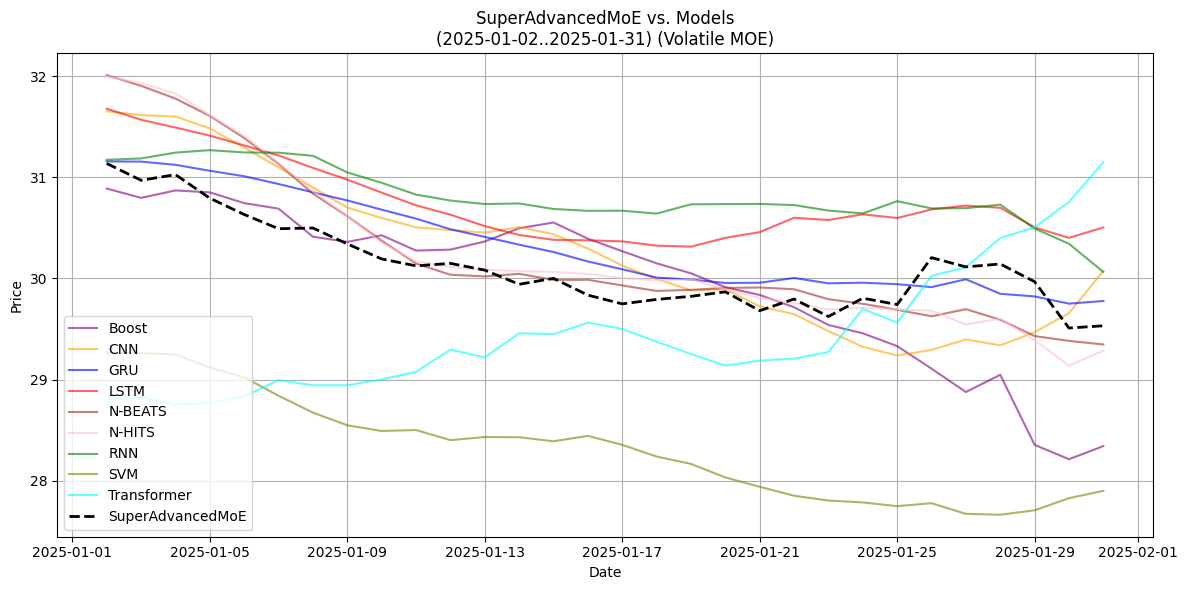

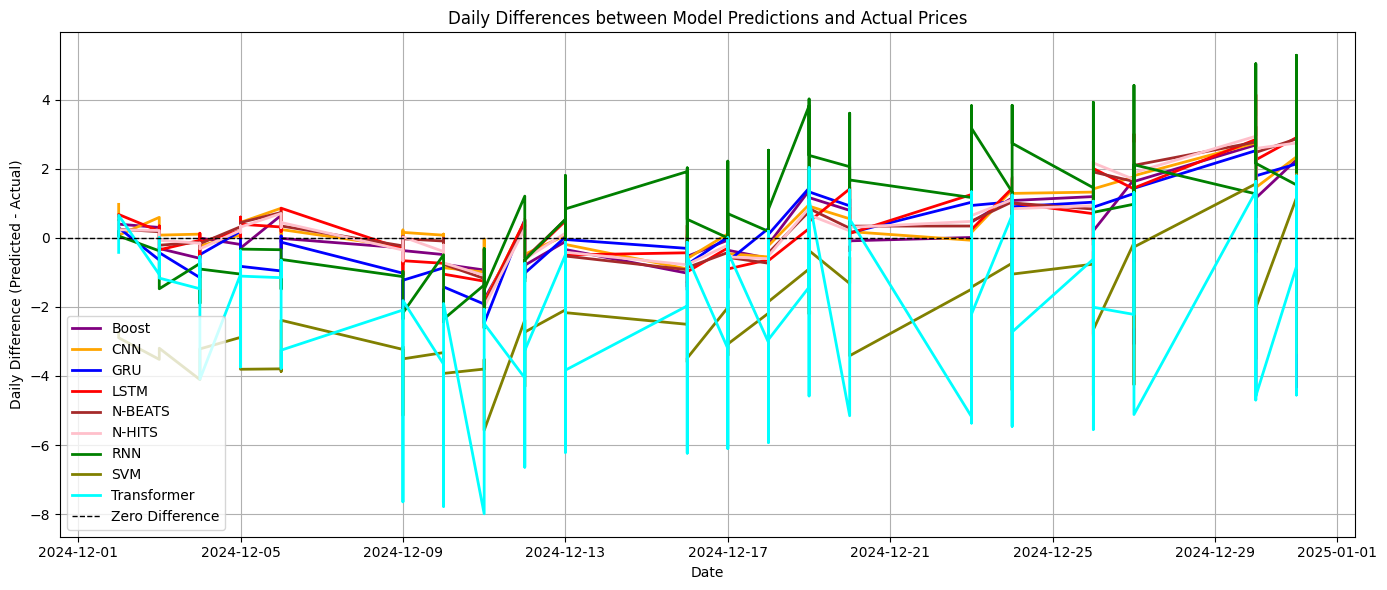

[MoE] Best polynomial degree: 4, Val MSE=0.022134

=== Polynomial Expressions for MoE ===
[MoE] (Degree 4) -> polynomial:
   y = -4.0622e-09*x^4+1.6340e-04*x^3-8.9456e-04*x^2-6.6060e+04*x+6.6431e+08
[MoE] (Degree 4) -> derivative:
   dy/dx = -1.6249e-08*x^3+4.9020e-04*x^2-1.7891e-03*x-6.6060e+04


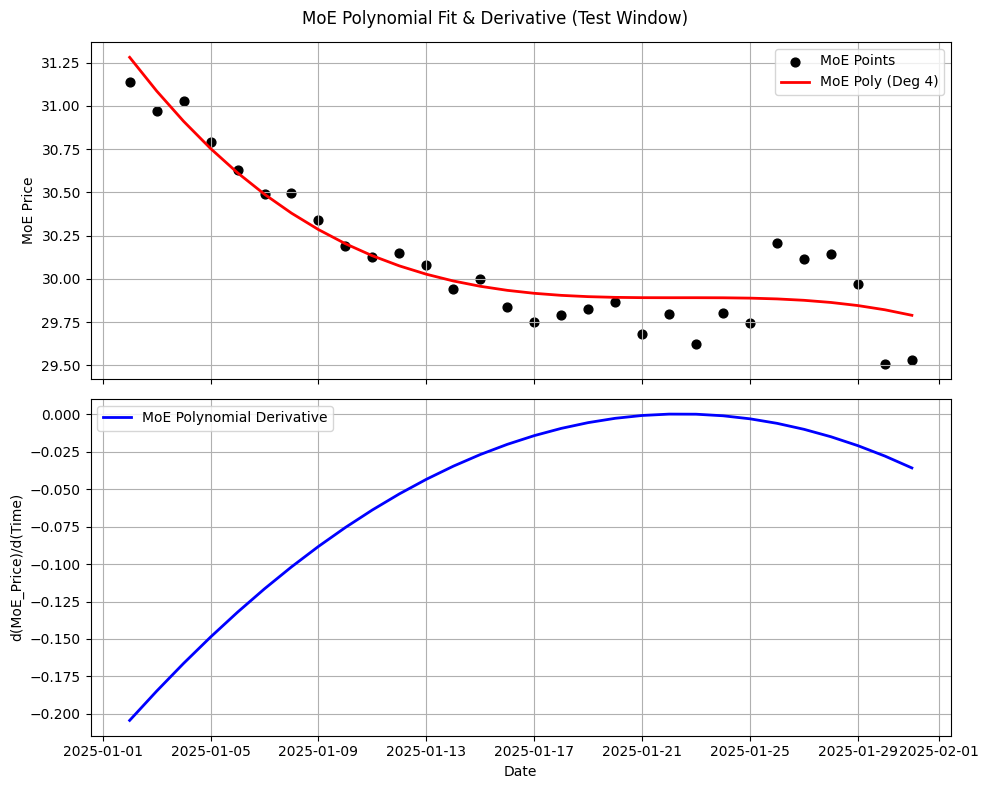


All done with daily difference + MoE polynomial fitting & derivatives!


In [5]:
###############################################################
# SUPER ADVANCED MOE SCRIPT (Encouraging Volatility)
# with Daily Difference Diagram + MoE Polynomial Fitting
# + Polynomial Expression Printing
###############################################################

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import os
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import joblib

from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor

from numpy.polynomial.polynomial import polyfit, polyval
import matplotlib.dates as mdates
from sklearn.metrics import mean_squared_error

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)
pd.options.mode.chained_assignment = None

# ---------------------------------------------------------------------
# 0) GLOBAL SETUP
# ---------------------------------------------------------------------
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

BEST_MODELS_DIR = "."   # Where .pt/.pkl model files are stored
features = ["Price", "Open", "High", "Low"]
WINDOW_SIZE = 35

TRAIN_CUTOFF = pd.to_datetime("2024-07-01")
VAL_CUTOFF   = pd.to_datetime("2024-11-30")
TEST_CUTOFF  = pd.to_datetime("2024-12-01")

# ---------------------------------------------------------------------
# 1) MODEL DEFINITIONS & LOADING
# ---------------------------------------------------------------------
class BaseModel(nn.Module):
    def __init__(self, model_type="LSTM", window_width=35):
        super().__init__()
        self.model_type = model_type

        if model_type == "CNN":
            self.conv1 = nn.Conv1d(4, 64, 3)
            self.conv2 = nn.Conv1d(64, 128, 3)
            with torch.no_grad():
                dummy = torch.zeros(1, 4, window_width)
                outdummy = self.conv2(F.relu(self.conv1(dummy)))
                conv_output_size = outdummy.shape[1]*outdummy.shape[2]
            self.fc = nn.Linear(conv_output_size, 4)

        elif model_type == "LSTM":
            self.rnn = nn.LSTM(4, 128, num_layers=2, batch_first=True, dropout=0.05)
            self.fc = nn.Linear(128, 4)

        elif model_type == "GRU":
            self.rnn = nn.GRU(4, 128, num_layers=2, batch_first=True, dropout=0.05)
            self.fc = nn.Linear(128, 4)

        elif model_type == "RNN":
            self.rnn = nn.RNN(4, 128, num_layers=2, nonlinearity="relu", batch_first=True, dropout=0.05)
            self.fc = nn.Linear(128, 4)

        elif model_type == "EnhancedLSTM":
            self.rnn = nn.LSTM(4, 128, num_layers=3, batch_first=True, dropout=0.1)
            self.bn  = nn.BatchNorm1d(128)
            self.dropout = nn.Dropout(0.1)
            self.fc = nn.Linear(128, 4)

        elif model_type == "Transformer":
            self.input_linear = nn.Linear(4, 128)
            enc_layer = nn.TransformerEncoderLayer(d_model=128, nhead=8, dropout=0.05)
            self.transformer_encoder = nn.TransformerEncoder(enc_layer, num_layers=3)
            self.fc = nn.Linear(128, 4)

        elif model_type in ["N-BEATS","N-HITS"]:
            self.input_size = window_width * 4
            self.blocks = nn.ModuleList([
                nn.Sequential(
                    nn.Linear(self.input_size, 128),
                    nn.ReLU(),
                    nn.Linear(128, 128),
                    nn.ReLU(),
                    nn.Linear(128, 4)
                ) for _ in range(3)
            ])
        else:
            raise ValueError(f"Invalid model_type: {model_type}")

    def forward(self, x):
        if self.model_type == "CNN":
            x = x.permute(0,2,1)
            x = F.relu(self.conv1(x))
            x = F.relu(self.conv2(x))
            x = x.view(x.size(0), -1)
            return self.fc(x)

        elif self.model_type in ["LSTM","GRU","RNN"]:
            out, _ = self.rnn(x)
            out = out[:, -1, :]
            return self.fc(out)

        elif self.model_type == "EnhancedLSTM":
            out, _ = self.rnn(x)
            out = out[:, -1, :]
            out = self.bn(out)
            out = self.dropout(out)
            return self.fc(out)

        elif self.model_type == "Transformer":
            x = self.input_linear(x)
            x = x.permute(1, 0, 2)  # => [window, batch, 128]
            x = self.transformer_encoder(x)
            x = x[-1, :, :]
            return self.fc(x)

        elif self.model_type in ["N-BEATS","N-HITS"]:
            xflat = x.reshape(x.size(0), -1)
            forecast = 0
            for block in self.blocks:
                forecast += block(xflat)
            return forecast

        else:
            raise ValueError("Invalid model_type")


class SklearnWrapper:
    def __init__(self, model):
        self.model = model
    def forward(self, x):
        arr = x.cpu().numpy().reshape(1, -1)
        pred = self.model.predict(arr)
        return torch.from_numpy(pred).float().to(x.device)
    def eval(self): pass
    def __call__(self, x):
        return self.forward(x)


def load_torch_model(model_type, window_size, path):
    if not os.path.exists(path):
        raise FileNotFoundError(f"File not found: {path}")
    print(f"[PyTorch] Loading {model_type} from {path}")
    net = BaseModel(model_type, window_size).to(device)
    net.load_state_dict(torch.load(path, map_location=device))
    net.eval()
    return net


def load_sklearn_model(model_type, path):
    if not os.path.exists(path):
        raise FileNotFoundError(f"File not found: {path}")
    print(f"[sklearn] Loading {model_type} => {path}")
    loaded = joblib.load(path)
    return SklearnWrapper(loaded)

# ---------------------------------------------------------------------
# 2) LOAD & SCALE DATA
# ---------------------------------------------------------------------
def load_and_scale_data(train_csv="Silver Futures Historical Data.csv",
                        complete_csv="Silver Futures Historical Data_Complete.csv"):
    df_train = pd.read_csv(train_csv)
    df_train["Date"] = pd.to_datetime(df_train["Date"], errors="coerce")
    for col in ["Vol.", "Change %"]:
        if col in df_train.columns:
            df_train.drop(columns=[col], errors="ignore", inplace=True)

    for feat in features:
        if feat not in df_train.columns:
            df_train[feat] = np.nan
        else:
            df_train[feat] = df_train[feat].astype(str).str.replace(",", "", regex=True)
            df_train[feat] = pd.to_numeric(df_train[feat], errors="coerce")

    df_train.sort_values("Date", inplace=True)
    df_train.reset_index(drop=True, inplace=True)

    train_cutoff = TRAIN_CUTOFF
    val_cutoff   = VAL_CUTOFF
    test_cutoff  = TEST_CUTOFF

    df_trn = df_train[df_train["Date"] < train_cutoff].copy()
    df_val = df_train[(df_train["Date"] >= train_cutoff) & (df_train["Date"] <= val_cutoff)].copy()
    df_tst = df_train[df_train["Date"] >= test_cutoff].copy()

    df_trn_nonan = df_trn.dropna(subset=features)
    scaler = MinMaxScaler()
    scaler.fit(df_trn_nonan[features])

    df_trn_scaled = df_trn.copy()
    if not df_trn_nonan.empty:
        df_trn_scaled.loc[df_trn_nonan.index, features] = scaler.transform(df_trn_nonan[features])

    df_val_scaled = df_val.copy()
    val_no_nan = df_val_scaled.dropna(subset=features)
    if not val_no_nan.empty:
        df_val_scaled.loc[val_no_nan.index, features] = scaler.transform(val_no_nan[features])

    df_tst_scaled = df_tst.copy()
    trn_mins = df_trn_nonan[features].min()
    df_tst_filled = df_tst_scaled[features].fillna(trn_mins)
    df_tst_scaled.loc[:, features] = scaler.transform(df_tst_filled)

    df_scaled = pd.concat([df_trn_scaled, df_val_scaled, df_tst_scaled], ignore_index=True)

    # also load the "complete" CSV
    df_complete = pd.read_csv(complete_csv)
    df_complete["Date"] = pd.to_datetime(df_complete["Date"], errors="coerce")
    for col in ["Vol.", "Change %"]:
        if col in df_complete.columns:
            df_complete.drop(columns=[col], errors="ignore", inplace=True)

    for feat in features:
        df_complete[feat] = df_complete[feat].astype(str).str.replace(",", "", regex=True).astype(float)

    df_complete.sort_values("Date", inplace=True)
    df_complete.reset_index(drop=True, inplace=True)

    return df_scaled, df_complete, scaler


# ---------------------------------------------------------------------
# 3) ROLLING FORECASTS (9 MODELS)
# ---------------------------------------------------------------------
def get_latest_window(df_actual, current_date, window=35, scaler=None):
    mask = df_actual["Date"] < current_date
    sub = df_actual.loc[mask].copy()
    sub.sort_values("Date", inplace=True)
    if len(sub) < window:
        return None
    sub[features] = sub[features].fillna(method="ffill").fillna(method="bfill")
    arr = scaler.transform(sub[features].iloc[-window:].values)
    return arr

def forecast_n_days_from_date(model, df_actual, start_date, window=35, horizon=30,
                              device=None, scaler=None, noise_std=0.05):
    """
    Mild random noise => final predictions => more "volatility".
    """
    def add_noise_4d(prices, std=0.01):
        noise = np.random.normal(0.0, std, size=prices.shape)
        return np.clip(prices + noise, a_min=0, a_max=None)

    arr_window = get_latest_window(df_actual, start_date, window, scaler)
    if arr_window is None:
        return pd.DataFrame()

    rolling_buffer = np.copy(arr_window)
    forecast_records = []
    cur_dt = pd.to_datetime(start_date)

    for i in range(horizon):
        X_in = torch.tensor(rolling_buffer, dtype=torch.float).unsqueeze(0).to(device)
        with torch.no_grad():
            out_scaled = model(X_in).cpu().numpy()[0]
        out_unscaled = scaler.inverse_transform(out_scaled.reshape(1, -1))[0]

        out_noisy = add_noise_4d(out_unscaled, noise_std)

        dayx = cur_dt + pd.Timedelta(days=i)
        forecast_records.append({
            "ForecastDate": dayx,
            "Pred_Price_unscaled": out_noisy[0],
            "Pred_Open_unscaled":  out_noisy[1],
            "Pred_High_unscaled":  out_noisy[2],
            "Pred_Low_unscaled":   out_noisy[3]
        })

        out_noisy_scaled = scaler.transform(out_noisy.reshape(1, -1))[0]
        rolling_buffer = np.vstack([rolling_buffer[1:], out_noisy_scaled.reshape(1, -1)])

    return pd.DataFrame(forecast_records)

def rolling_train_validate_predict_moe(
    df_full, scaler_obj, model_types,
    start_train_cutoff=TRAIN_CUTOFF,
    start_val_cutoff=VAL_CUTOFF,
    start_pred=TEST_CUTOFF,
    end_pred=pd.to_datetime("2025-01-02"),
    horizon_days=30,
    do_daily_plots=False
):
    df_sorted = df_full.copy()
    df_sorted.sort_values("Date", inplace=True)

    date_rng = pd.date_range(start_pred, end_pred, freq="D")
    all_records = []

    for i, day_i in enumerate(date_rng):
        train_cutoff_i = start_train_cutoff + pd.Timedelta(days=i)
        val_cutoff_i   = start_val_cutoff   + pd.Timedelta(days=i)

        print(f"\n=== Rolling Day {day_i.date()} ===")
        print(f"  train_cutoff={train_cutoff_i.date()}  val_cutoff={val_cutoff_i.date()}")
        print(f"  Forecast next {horizon_days} days from {day_i.date()} (with mild noise)")

        # Load each model
        model_dict = {}
        for mt in model_types:
            out_file = f"best_{mt}_{day_i.strftime('%Y-%m-%d')}_V1"
            if mt in ["SVM","GPR","Boost"]:
                out_file += ".pkl"
                net = load_sklearn_model(mt, os.path.join(BEST_MODELS_DIR, out_file))
            else:
                out_file += ".pt"
                net = load_torch_model(mt, WINDOW_SIZE, os.path.join(BEST_MODELS_DIR, out_file))
            model_dict[mt] = net

        # Forecast from day_i
        for mt, netobj in model_dict.items():
            df_fc = forecast_n_days_from_date(
                model=netobj,
                df_actual=df_sorted,
                start_date=day_i,
                window=WINDOW_SIZE,
                horizon=horizon_days,
                device=device,
                scaler=scaler_obj,
                noise_std=0.01
            )
            if not df_fc.empty:
                df_fc["BaseDate"] = day_i
                df_fc["Model"]    = mt
                all_records.append(df_fc)

    df_all = pd.concat(all_records, ignore_index=True) if all_records else pd.DataFrame()
    df_all.sort_values(["Model","BaseDate","ForecastDate"], inplace=True)
    return df_all

# ---------------------------------------------------------------------
# 4) BUILD SUPER ADVANCED MoE
# ---------------------------------------------------------------------
def build_mini_models_table(final_rolling_fcst, df_actual):
    """
    For each (model, baseDate), measure performance in Dec'24 => weighting factors
    """
    start_jan = pd.to_datetime("2024-12-01")
    end_jan   = pd.to_datetime("2025-01-01")

    df_jan = final_rolling_fcst[
        (final_rolling_fcst["ForecastDate"] >= start_jan) &
        (final_rolling_fcst["ForecastDate"] <= end_jan)
    ].copy()
    if df_jan.empty:
        return pd.DataFrame(), 0.01

    df_act_jan = df_actual[
        (df_actual["Date"] >= start_jan) &
        (df_actual["Date"] <= end_jan)
    ].copy()
    df_act_jan.rename(columns={"Date":"ForecastDate","Price":"ActualPrice"}, inplace=True)

    df_merge = pd.merge(
        df_jan[["Model","BaseDate","ForecastDate","Pred_Price_unscaled"]],
        df_act_jan[["ForecastDate","ActualPrice"]],
        on="ForecastDate",
        how="inner"
    )
    df_merge["AbsError"] = (df_merge["Pred_Price_unscaled"] - df_merge["ActualPrice"]).abs()

    # mae per (model,baseDate)
    g_mae = df_merge.groupby(["Model","BaseDate"])["AbsError"].mean().reset_index()
    g_mae.rename(columns={"AbsError":"mae_jan"}, inplace=True)

    def poly_slope_diff(sub):
        sub = sub.sort_values("ForecastDate")
        xvals = np.arange(len(sub))
        yvals = sub["Pred_Price_unscaled"].values
        if len(yvals) < 4:
            return 0.5
        coefs = polyfit(xvals, yvals, deg=2)
        y_pred = polyval(xvals, coefs)
        sse = np.mean((yvals - y_pred)**2)
        return float(np.exp(-sse))

    def group_slope_func(grp):
        grp["slopeAlign_jan"] = poly_slope_diff(grp)
        return grp

    df_slope = df_merge.groupby(["Model","BaseDate"], group_keys=False).apply(group_slope_func)
    df_slope_agg = df_slope.groupby(["Model","BaseDate"])["slopeAlign_jan"].mean().reset_index()

    df_act_jan_sorted = df_act_jan.drop_duplicates("ForecastDate").copy()
    df_act_jan_sorted.sort_values("ForecastDate", inplace=True)
    df_act_jan_sorted["DayChange"] = df_act_jan_sorted["ActualPrice"].diff()
    real_vol = df_act_jan_sorted["DayChange"].std(skipna=True)
    if pd.isna(real_vol) or real_vol < 1e-9:
        real_vol = 0.01

    def mini_volatility(sub):
        sub = sub.sort_values("ForecastDate")
        sub["DayChange"] = sub["Pred_Price_unscaled"].diff()
        vol_ = sub["DayChange"].std(skipna=True)
        if pd.isna(vol_):
            vol_ = 0.01
        return vol_

    g_vol = df_merge.groupby(["Model","BaseDate"]).apply(mini_volatility).reset_index()
    g_vol.rename(columns={0:"predVol_jan"}, inplace=True)

    def vol_align(v):
        ratio = v / real_vol
        return np.exp(-abs(ratio - 1.0))

    g_vol["volAlign_jan"] = g_vol["predVol_jan"].apply(vol_align)

    mini_models = pd.merge(g_mae, df_slope_agg, on=["Model","BaseDate"], how="left")
    mini_models = pd.merge(
        mini_models,
        g_vol[["Model","BaseDate","predVol_jan","volAlign_jan"]],
        on=["Model","BaseDate"],
        how="left"
    )

    # mae => baseAcc
    mae_min = mini_models["mae_jan"].min()
    mae_max = mini_models["mae_jan"].max()
    if np.isclose(mae_min, mae_max):
        mini_models["baseAcc"] = 1.0
    else:
        mini_models["baseAcc"] = 1.0 - ((mini_models["mae_jan"] - mae_min)/(mae_max - mae_min))

    return mini_models, real_vol

def compute_super_advanced_moe(final_rolling_fcst, df_actual):
    """
    Weighted sum => mixture-of-experts + mild noise
    """
    print("\n=== SUPER ADVANCED MOE w/ Polynomials & Voting ===\n")
    mini_models, real_vol = build_mini_models_table(final_rolling_fcst, df_actual)
    if mini_models.empty:
        print("No january data => fallback => uniform daily average")
        return pd.DataFrame(columns=["ForecastDate","MOE_Price"])

    mm_dict = {}
    for i,row in mini_models.iterrows():
        mm_dict[(row["Model"], row["BaseDate"])] = {
            "baseAcc": row["baseAcc"],
            "slopeAlign_jan": row["slopeAlign_jan"],
            "volAlign_jan": row["volAlign_jan"]
        }

    start_moe = pd.to_datetime("2025-01-02")
    end_moe   = pd.to_datetime("2025-01-31")
    all_days  = pd.date_range(start_moe, end_moe, freq="D")
    records   = []

    for d in all_days:
        df_d = final_rolling_fcst[final_rolling_fcst["ForecastDate"] == d].copy()
        if df_d.empty:
            continue

        d_prev = d - pd.Timedelta(days=1)
        ups=0
        downs=0
        total=0
        w_sums=0.0
        weighted_price=0.0

        for idx, row in df_d.iterrows():
            m  = row["Model"]
            bD = row["BaseDate"]
            if (m,bD) not in mm_dict:
                continue
            baseAcc = mm_dict[(m,bD)]["baseAcc"]
            slopeA  = mm_dict[(m,bD)]["slopeAlign_jan"]
            volA    = mm_dict[(m,bD)]["volAlign_jan"]

            df_dprev = final_rolling_fcst[
                (final_rolling_fcst["Model"] == m) &
                (final_rolling_fcst["BaseDate"] == bD) &
                (final_rolling_fcst["ForecastDate"] == d_prev)
            ]
            if df_dprev.empty:
                dirFactor = 1.0
            else:
                pd_today = row["Pred_Price_unscaled"]
                pd_yest  = df_dprev["Pred_Price_unscaled"].values[0]
                if pd_today > pd_yest:
                    ups += 1
                    dirFactor = 1.1
                elif pd_today < pd_yest:
                    downs += 1
                    dirFactor = 0.9
                else:
                    dirFactor = 1.0
                total += 1

            w = baseAcc*slopeA*volA*dirFactor
            w_sums += w
            weighted_price += w * row["Pred_Price_unscaled"]

        if np.isclose(w_sums, 0.0):
            day_moe = df_d["Pred_Price_unscaled"].mean()
        else:
            day_moe = weighted_price / w_sums

        if total > 0:
            fraction_up   = ups / total
            fraction_down = downs / total
            if fraction_up > 0.7:
                day_moe *= 1.01
            elif fraction_down > 0.7:
                day_moe *= 0.99

        # final mild random noise => more "volatility"
        day_moe += np.random.normal(0, day_moe * 0.002)

        records.append({"ForecastDate": d, "MOE_Price": day_moe})

    df_moe = pd.DataFrame(records)
    df_moe.sort_values("ForecastDate", inplace=True)
    return df_moe

def plot_super_advanced_moe_vs_models(
    final_rolling_fcst, df_moe,
    from_d=pd.to_datetime("2025-01-02"),
    to_d=pd.to_datetime("2025-01-31")
):
    """
    Plots all 9 models + super advanced MoE in [from_d..to_d] (no actual).
    """
    df_sel = final_rolling_fcst[
        (final_rolling_fcst["ForecastDate"] >= from_d) &
        (final_rolling_fcst["ForecastDate"] <= to_d)
    ].copy()

    plt.figure(figsize=(12,6))
    color_map = {
        "LSTM":"red","GRU":"blue","RNN":"green","CNN":"orange","EnhancedLSTM":"magenta",
        "Transformer":"cyan","N-BEATS":"brown","N-HITS":"pink","SVM":"olive","GPR":"teal","Boost":"purple"
    }

    for m in df_sel["Model"].unique():
        df_m = df_sel[df_sel["Model"] == m].copy()
        df_m_agg = df_m.groupby("ForecastDate", as_index=False)["Pred_Price_unscaled"].mean()
        c = color_map.get(m, "gray")
        plt.plot(df_m_agg["ForecastDate"], df_m_agg["Pred_Price_unscaled"], color=c, alpha=0.6, label=m)

    df_moe_sub = df_moe[(df_moe["ForecastDate"] >= from_d) & (df_moe["ForecastDate"] <= to_d)]
    if not df_moe_sub.empty:
        plt.plot(df_moe_sub["ForecastDate"], df_moe_sub["MOE_Price"],
                 color="black", linestyle="--", lw=2, label="SuperAdvancedMoE")

    plt.title(f"SuperAdvancedMoE vs. Models\n({from_d.date()}..{to_d.date()}) (Volatile MOE)")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# ---------------------------------------------------------------------
# 5) DAILY DIFFERENCE DIAGRAM for All 9 Models vs. Actual
# ---------------------------------------------------------------------
def plot_daily_difference(final_rolling_fcst, df_actual, start_test=TEST_CUTOFF):
    """
    Plots daily difference: (Predicted - Actual) for each model in the test region or beyond.
    Expects df_actual to have columns ["Date", "Price"].
    """
    # Filter actual to test region
    df_act_test = df_actual[df_actual["Date"] >= start_test][["Date","Price"]].copy()
    df_act_test.sort_values("Date", inplace=True)

    # Build difference data
    # For each row in final_rolling_fcst, find the matching date in df_act_test => difference
    df_fc = final_rolling_fcst.copy()
    df_fc.rename(columns={"ForecastDate":"Date"}, inplace=True)
    df_fc.sort_values(["Model","Date"], inplace=True)

    merged = pd.merge(df_fc, df_act_test, on="Date", how="inner", suffixes=("","_Actual"))
    merged["DailyDiff"] = merged["Pred_Price_unscaled"] - merged["Price"]

    plt.figure(figsize=(14,6))
    color_map = {
        "LSTM":"red","GRU":"blue","RNN":"green","CNN":"orange","EnhancedLSTM":"magenta",
        "Transformer":"cyan","N-BEATS":"brown","N-HITS":"pink","SVM":"olive","Boost":"purple"
    }

    for m in merged["Model"].unique():
        df_sub = merged[merged["Model"] == m].copy()
        df_sub.sort_values("Date", inplace=True)
        c = color_map.get(m, "gray")
        plt.plot(df_sub["Date"], df_sub["DailyDiff"], color=c, linewidth=2, label=m)

    plt.axhline(0, color="black", linestyle="--", linewidth=1, label="Zero Difference")
    plt.xlabel("Date")
    plt.ylabel("Daily Difference (Predicted - Actual)")
    plt.title("Daily Differences between Model Predictions and Actual Prices")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# ---------------------------------------------------------------------
# 6) POLYNOMIAL FITTING & DERIVATIVES FOR THE MoE CURVE
# ---------------------------------------------------------------------
def format_polynomial(coeffs):
    """
    Convert polynomial coefficients (highest degree first)
    into a readable expression like we did before.
    """
    # np.polyfit returns [an, an-1, ..., a0] in descending order
    # We'll build terms from highest power to lowest
    deg = len(coeffs) - 1
    terms = []
    for i, c in enumerate(coeffs):
        power = deg - i
        sign_str = "+" if c >= 0 else "-"
        abs_val = abs(c)

        if power > 1:
            term = f"{sign_str}{abs_val:.4e}*x^{power}"
        elif power == 1:
            term = f"{sign_str}{abs_val:.4e}*x"
        else:
            term = f"{sign_str}{abs_val:.4e}"
        terms.append(term)

    expr = "".join(terms)
    # fix if expression starts with '+'
    if expr.startswith("+"):
        expr = expr[1:]
    # convert '+-' => '-'
    expr = expr.replace("+-", "-")
    return expr

def derivative_expression(coeffs):
    d_coeffs = np.polyder(coeffs)
    return format_polynomial(d_coeffs)

def fit_polynomial_to_moe_curve(
    df_moe, date_col="ForecastDate", price_col="MOE_Price",
    start_date=pd.to_datetime("2025-01-02"), end_date=pd.to_datetime("2025-01-31"),
    degree_candidates=range(1,36), do_plot=True
):
    """
    1) Filter df_moe to [start_date..end_date].
    2) Train/Val split by even/odd index => find best polynomial degree.
    3) Plot the best polynomial & derivative + overlay the actual Price data.
    4) Print out polynomial + derivative expression.
    """
    df_fit = df_moe.copy()
    df_fit[date_col] = pd.to_datetime(df_fit[date_col])
    mask = (df_fit[date_col] >= start_date) & (df_fit[date_col] <= end_date)
    df_fit = df_fit.loc[mask].dropna(subset=[price_col]).copy()
    df_fit.sort_values(date_col, inplace=True)
    if df_fit.empty:
        print("No MoE data in the specified date range.")
        return None

    df_fit["mdates_num"] = mdates.date2num(df_fit[date_col])
    indices = np.arange(len(df_fit))
    train_mask = (indices % 2 == 0)
    val_mask   = ~train_mask
    x_train = df_fit.loc[train_mask, "mdates_num"].values
    y_train = df_fit.loc[train_mask, price_col].values
    x_val   = df_fit.loc[val_mask,   "mdates_num"].values
    y_val   = df_fit.loc[val_mask,   price_col].values

    best_deg = None
    best_mse = float("inf")
    best_coeffs = None

    for d in degree_candidates:
        coeffs = np.polyfit(x_train, y_train, deg=d)
        y_val_pred = np.polyval(coeffs, x_val)
        mse_val = mean_squared_error(y_val, y_val_pred)
        if mse_val < best_mse:
            best_mse = mse_val
            best_deg = d
            best_coeffs = coeffs

    print(f"[MoE] Best polynomial degree: {best_deg}, Val MSE={best_mse:.6f}")
    df_fit["MoE_PolyFit"]   = np.polyval(best_coeffs, df_fit["mdates_num"])
    d_coeffs = np.polyder(best_coeffs)
    df_fit["MoE_PolyDeriv"] = np.polyval(d_coeffs, df_fit["mdates_num"])

    # Print expressions
    poly_expr   = format_polynomial(best_coeffs)
    deriv_expr  = derivative_expression(best_coeffs)

    print("\n=== Polynomial Expressions for MoE ===")
    print(f"[MoE] (Degree {best_deg}) -> polynomial:\n   y = {poly_expr}")
    print(f"[MoE] (Degree {best_deg}) -> derivative:\n   dy/dx = {deriv_expr}")

    # Optional plot
    if do_plot:
        fig, ax = plt.subplots(2, 1, figsize=(10,8), sharex=True)
        # Top: MoE curve
        ax[0].scatter(df_fit[date_col], df_fit[price_col], color="black", label="MoE Points", s=40)
        ax[0].plot(df_fit[date_col], df_fit["MoE_PolyFit"], color="red", linewidth=2,
                   label=f"MoE Poly (Deg {best_deg})")
        ax[0].set_ylabel("MoE Price")
        ax[0].legend()
        ax[0].grid(True)

        # Bottom: derivative
        ax[1].plot(df_fit[date_col], df_fit["MoE_PolyDeriv"], color="blue", linewidth=2,
                   label="MoE Polynomial Derivative")
        ax[1].set_ylabel("d(MoE_Price)/d(Time)")
        ax[1].set_xlabel("Date")
        ax[1].legend()
        ax[1].grid(True)

        plt.suptitle("MoE Polynomial Fit & Derivative (Test Window)")
        plt.tight_layout()
        plt.show()

    return {
        "degree": best_deg,
        "coeffs": best_coeffs,
        "val_mse": best_mse,
        "df_fit": df_fit
    }

# ---------------------------------------------------------------------
# 7) MAIN
# ---------------------------------------------------------------------
if __name__ == "__main__":
    # 1) Load & scale data
    df_scaled, df_complete_all, scaler = load_and_scale_data(
        "Silver Futures Historical Data.csv",
        "Silver Futures Historical Data_Complete.csv"
    )

    # 2) Rolling forecast with 9 models => final_rolling_fc
    model_list = ["LSTM","GRU","RNN","CNN","Transformer","N-BEATS","N-HITS","SVM","Boost"]
    final_rolling_fc = rolling_train_validate_predict_moe(
        df_full=df_complete_all,
        scaler_obj=scaler,
        model_types=model_list,
        start_train_cutoff=TRAIN_CUTOFF,
        start_val_cutoff=VAL_CUTOFF,
        start_pred=TEST_CUTOFF,
        end_pred=pd.to_datetime("2025-01-02"),
        horizon_days=30,
        do_daily_plots=False
    )
    print("\n=== HEAD of final_rolling_fc ===")
    print(final_rolling_fc.head(25))

    # 3) Build MoE
    df_moe = compute_super_advanced_moe(final_rolling_fc, df_complete_all)
    print("\n=== HEAD of df_moe (Mixture-of-Experts) ===")
    print(df_moe.head())

    # 4) Plot MoE vs. the 9 model lines
    plot_super_advanced_moe_vs_models(
        final_rolling_fc,
        df_moe,
        from_d=pd.to_datetime("2025-01-02"),
        to_d=pd.to_datetime("2025-01-31")
    )

    # 5) Plot the daily difference: 9 models vs. actual
    plot_daily_difference(final_rolling_fc, df_complete_all, start_test=TEST_CUTOFF)

    # 6) Polynomial fitting & derivative for the MoE curve
    #    Over Jan 2..Jan 31, 2025 (like the test window)
    moe_poly_res = fit_polynomial_to_moe_curve(
        df_moe=df_moe,
        start_date=pd.to_datetime("2025-01-02"),
        end_date=pd.to_datetime("2025-01-31"),
        degree_candidates=range(1,36),
        do_plot=True
    )

    print("\nAll done with daily difference + MoE polynomial fitting & derivatives!")
